In [162]:
import os
import azureml.core
import pandas as pd
import numpy as np
import logging
import warnings

from pandas.tseries.frequencies import to_offset

# Squash warning messages for cleaner output in the notebook
warnings.showwarning = lambda *args, **kwargs: None

np.set_printoptions(precision=4, suppress=True, linewidth=120)

from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig
from azureml.automl.core.featurization import FeaturizationConfig
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from azureml.train.estimator import Estimator

from pandas.io.json import json_normalize
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.4f' % x)
#sns.set_context("paper", font_scale=1.3)
#sns.set_style('white')

import datetime
from dateutil.tz import tzutc
#https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/automated-machine-learning/forecasting-orange-juice-sales/auto-ml-forecasting-orange-juice-sales.ipynb

In [163]:
print("This notebook was created using version 1.18.0 of the Azure ML SDK")
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK")

This notebook was created using version 1.18.0 of the Azure ML SDK
You are currently using version 1.18.0 of the Azure ML SDK


In [164]:
%run ./helper.ipynb

In [165]:
#read input files
time_column_name = 'End of Month'
time_column_name1 = 'Snapshot Date Short'
talenthist = pd.read_csv("TalentHistory.csv", parse_dates=[time_column_name])
pipehist = pd.read_csv("PipelineHistory.csv", parse_dates=[time_column_name,time_column_name1])
revhist = pd.read_csv("RevenueHistory.csv", parse_dates=[time_column_name])
opphist = pd.read_csv("OppHistory.csv", parse_dates=[time_column_name])
projhist = pd.read_csv("ProjectHistory.csv", parse_dates=[time_column_name])
time_column_name2 = 'Latest Snapshot Date Short'
pipetrend = pd.read_csv("PipelineTrend.csv", parse_dates=[time_column_name2])
display(talenthist.tail())
display(pipehist.tail())
display(revhist.tail())
display(opphist.tail())
display(projhist.tail())
display(pipetrend.tail())

,End of Month,Contrib Fin Entity ID,Headcount,Headcount Contingent
290,2021-11-30,CHN,25.00,nan
291,2021-11-30,DEU,25.00,1.00
292,2021-11-30,GBR,42.00,4.00
293,2021-11-30,JPN,33.00,nan
294,2021-11-30,USA,371.95,14.00


,Snapshot Date Short,Relative Snapshot Month Offset,End of Month,Relative Month Offset,Contrib Fin Entity ID,Pipeline,Pipeline 3 Month Rolling Avg
7006,2020-12-14,0,2021-10-31,10,USA,311726.69,999959.29
7007,2020-12-14,0,2021-11-30,11,CHN,757.00,90464.60
7008,2020-12-14,0,2021-11-30,11,DEU,47652.52,59976.84
7009,2020-12-14,0,2021-11-30,11,GBR,nan,269611.47
7010,2020-12-14,0,2021-11-30,11,USA,211008.49,567410.01


,End of Month,Managing Fin Entity ID,Revenue
234,2020-11-30,USA,10175727.47
235,2020-12-31,USA,557736.30
236,2021-01-31,USA,1443196.00
237,2021-02-28,USA,1296579.00
238,2021-03-31,USA,1066371.00


,End of Month,Managing Fin Entity ID,Current Opp. Period Value
141,2020-11-30,USA,13478001.00
142,2020-12-31,CHN,605600.00
143,2020-12-31,GBR,158484.00
144,2020-12-31,JPN,132960.00
145,2020-12-31,USA,9376240.00


,End of Month,Managing Fin Entity ID,Conversions
195,2020-12-31,CHN,53391.00
196,2020-12-31,DEU,890837.60
197,2020-12-31,GBR,324500.00
198,2020-12-31,JPN,9600.00
199,2020-12-31,USA,2553159.00


,Latest Snapshot Date Short,Relative Snapshot Month Offset,Contrib Fin Entity ID,Pipeline Trend
145,2020-12-14,0,CHN,7410197.26
146,2020-12-14,0,DEU,5777384.36
147,2020-12-14,0,GBR,9176173.79
148,2020-12-14,0,JPN,4908708.38
149,2020-12-14,0,USA,80493235.27



 SP500: 



'SP500'


 DF Info: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 0 to 59
Data columns (total 2 columns):
End_of_Month    60 non-null datetime64[ns]
sp500           60 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.4 KB


None


 SP500 Describe: 



,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
End_of_Month,60,60,2017-11-30,1,2016-01-31,2020-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sp500,60.000000,NaN,NaT,NaN,NaT,NaT,2691.058333,420.158368,1932.230000,2379.060000,2708.505000,2947.927500,3647.490000



 SP500 Head: 



,End_of_Month,sp500
0,2016-01-31,1940.240000
1,2016-02-29,1932.230000
2,2016-03-31,2059.740000
3,2016-04-30,2065.300000
4,2016-05-31,2096.960000



 SP500 Tail: 



,End_of_Month,sp500
55,2020-08-31,3500.310000
56,2020-09-30,3363.000000
57,2020-10-31,3269.960000
58,2020-11-30,3621.630000
59,2020-12-31,3647.490000


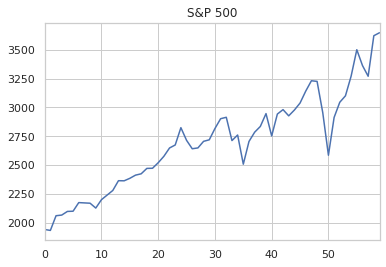

In [166]:
#download SP500 closing prices
#if you get an error after executing the code, try adding below. 
#!pip install pandas-datareader

pd.set_option('display.float_format', lambda x: '%.6f' % x)

start = datetime.datetime(2016, 1, 1)
end = today
#pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
#SP500 = web.DataReader(['sp500'], 'fred', start, end)
#display(SP500.head())

import pandas_datareader as pdr

SP500 = pdr.get_data_fred('sp500', start, end)
SP500 = SP500.reset_index(level=SP500.index.names)
SP500['End_of_Month'] = SP500['DATE']+ pd.offsets.MonthEnd(0)
SP500 = SP500.sort_values('DATE').groupby('End_of_Month').last()
#SP500['Monthly_Return'] = (SP500['sp500']/ SP500['sp500'].shift(1)) -1
#SP500['sp500_1M_Previous'] = SP500['sp500'].shift(1)
SP500 = SP500.drop('DATE', axis=1)
SP500 = SP500.reset_index(level=SP500.index.names)

#Drop all Not a number values using drop method.
SP500.dropna(inplace = True)
print("\n SP500: \n")
display(get_df_name(SP500))
print("\n DF Info: \n")
display(SP500.info(verbose=True))
print("\n SP500 Describe: \n")
display(SP500.describe(include='all').transpose().head())
print("\n SP500 Head: \n")
display(SP500.head())
print("\n SP500 Tail: \n")
display(SP500.tail())
SP500['sp500'].plot(title='S&P 500')

In [167]:
#create an Experiment. An Experiment corresponds to a prediction problem you are trying to solve, while a Run corresponds to a specific approach to the problem.
ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = 'revenue-time-forecast'

experiment = Experiment(ws, experiment_name)

output = {}
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['SKU'] = ws.sku
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
Subscription ID,db61fd47-db56-45e3-844f-1b1f5c47990a
Workspace,dwmlazwu01
SKU,Enterprise
Resource Group,BI-DevQA-RG
Location,westus2
Run History Name,revenue-time-forecast


In [168]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
amlcompute_cluster_name = "cibimldev01"

compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
print('Found existing cluster, use it.')

Found existing cluster, use it.


In [169]:
#Rename Studio, filter studio and prep data
pd.set_option('display.float_format', lambda x: '%.2f' % x)
#exclude_studio = ["Regional Bay Area", "Regional ChiCamNY", "Palo Alto", "Singapore", "Unknown", "North America"]

#display(exclude_studio)
talenthist1 = talenthist.copy()
pipehist1 = pipehist.copy()
opphist1 = opphist.copy()
projhist1 = projhist.copy()
revhist1 = revhist.copy()
pipetrend1 = pipetrend.copy()
talenthist1.columns = talenthist1.columns.astype(str).str.replace("Contrib ", "")
pipehist1.columns = pipehist1.columns.astype(str).str.replace("Contrib ", "")
pipetrend1.columns = pipetrend1.columns.astype(str).str.replace("Contrib ", "")
opphist1.columns = opphist1.columns.astype(str).str.replace("Managing ", "")
projhist1.columns = projhist1.columns.astype(str).str.replace("Managing ", "")
revhist1.columns = revhist1.columns.astype(str).str.replace("Managing ", "")
#talenthist1 = talenthist.rename(columns={"Contrib Studio Name": "Studio"})
#pipehist1 = pipehist.rename(columns={"Contrib Studio Name": "Studio"})

#revhist1 = revhist.rename(columns={"Managing Studio Name": "Studio"})
pipetrend1 = pipetrend1.rename(columns={"Latest Snapshot Date Short": "End of Month",
                                       #"Contrib Studio Name": "Studio", 
                                       "Relative Snapshot Month Offset": "Relative Month Offset"})
#opphist1 = opphist.rename(columns={"Managing Studio Name": "Studio"})
#projhist1 = projhist.rename(columns={"Managing Studio Name": "Studio"})
#revhist1 = revhist1.query('End_of_Month < @current_eom').reset_index(drop=True)
display(pipetrend1)
cols_float1 = opphist1.filter(like='Rate', axis=1).columns
remove_percetage(opphist1, cols_float1)
cols_float2 = pipehist1.filter(like='Yield', axis=1).columns
remove_percetage(pipehist1, cols_float2)

talenthist1 = data_prep(talenthist1)
pipehist1 = data_prep(pipehist1)
revhist1 = data_prep(revhist1)
pipetrend1 = data_prep(pipetrend1)
opphist1 = data_prep(opphist1)
projhist1 = data_prep(projhist1)
display(pipetrend1)
coerce_df_columns_to_numeric(talenthist1)
coerce_df_columns_to_numeric(revhist1)
coerce_df_columns_to_numeric(opphist1)
coerce_df_columns_to_numeric(projhist1)
coerce_df_columns_to_numeric(pipehist1)
coerce_df_columns_to_numeric(pipetrend1)
display(pipetrend1)
show_stats(pipehist1)

#revhist1 = revhist1.query('Fin_Entity_ID not in ["SGP",0]').copy()
pipehist1['Snapshot_Date_Short'] = pipehist1['Snapshot_Date_Short'] + pd.offsets.MonthEnd(0) #make sure all End of Month are end of month dates
pipehist1['End_of_Month'] = pipehist1['End_of_Month'] + pd.offsets.MonthEnd(0) #make sure all End of Month are end of month dates
pipetrend1['End_of_Month'] = pipetrend1['End_of_Month'] + pd.offsets.MonthEnd(0) #make sure all End of Month are end of month dates
opphist1['End_of_Month'] = opphist1['End_of_Month'] + pd.offsets.MonthEnd(0) 
projhist1['End_of_Month'] = projhist1['End_of_Month'] + pd.offsets.MonthEnd(0) 

#Sort
pipehist1.sort_values(by=['Snapshot_Date_Short','End_of_Month','Fin_Entity_ID']).reset_index(drop=True)
revhist1.sort_values(by=['End_of_Month','Fin_Entity_ID']).reset_index(drop=True)
talenthist1.sort_values(by=['End_of_Month','Fin_Entity_ID']).reset_index(drop=True)
pipetrend1.sort_values(by=['End_of_Month','Fin_Entity_ID']).reset_index(drop=True)
opphist1.sort_values(by=['End_of_Month','Fin_Entity_ID']).reset_index(drop=True)
projhist1.sort_values(by=['End_of_Month','Fin_Entity_ID']).reset_index(drop=True)

display(talenthist.tail())
display(pipehist.tail())
display(revhist.tail())
display(opphist.tail())
display(projhist.tail())
display(pipetrend.tail())

,End of Month,Relative Month Offset,Fin Entity ID,Pipeline Trend
0,2018-07-31,-29,CHN,3212869.57
1,2018-07-31,-29,DEU,3212238.90
2,2018-07-31,-29,GBR,5941237.41
3,2018-07-31,-29,JPN,5897372.68
4,2018-07-31,-29,USA,119243803.66
...,...,...,...,...
145,2020-12-14,0,CHN,7410197.26
146,2020-12-14,0,DEU,5777384.36
147,2020-12-14,0,GBR,9176173.79
148,2020-12-14,0,JPN,4908708.38


,End_of_Month,Relative_Month_Offset,Fin_Entity_ID,Pipeline_Trend
0,2018-07-31,-29,CHN,3212869.57
1,2018-07-31,-29,DEU,3212238.90
2,2018-07-31,-29,GBR,5941237.41
3,2018-07-31,-29,JPN,5897372.68
4,2018-07-31,-29,USA,119243803.66
...,...,...,...,...
145,2020-12-14,0,CHN,7410197.26
146,2020-12-14,0,DEU,5777384.36
147,2020-12-14,0,GBR,9176173.79
148,2020-12-14,0,JPN,4908708.38


,End_of_Month,Relative_Month_Offset,Fin_Entity_ID,Pipeline_Trend
0,2018-07-31,-29,CHN,3212869
1,2018-07-31,-29,DEU,3212238
2,2018-07-31,-29,GBR,5941237
3,2018-07-31,-29,JPN,5897372
4,2018-07-31,-29,USA,119243803
...,...,...,...,...
145,2020-12-14,0,CHN,7410197
146,2020-12-14,0,DEU,5777384
147,2020-12-14,0,GBR,9176173
148,2020-12-14,0,JPN,4908708



 DF Name: 



'pipehist1'


 DF Info: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7011 entries, 0 to 7010
Data columns (total 7 columns):
Snapshot_Date_Short               7011 non-null datetime64[ns]
Relative_Snapshot_Month_Offset    7011 non-null int64
End_of_Month                      7011 non-null datetime64[ns]
Relative_Month_Offset             7011 non-null int64
Fin_Entity_ID                     7011 non-null object
Pipeline                          7011 non-null int64
Pipeline_3_Month_Rolling_Avg      7011 non-null int64
dtypes: datetime64[ns](2), int64(4), object(1)
memory usage: 438.2+ KB


None


 DF Describe: 



,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Snapshot_Date_Short,7011,30,2020-12-14 00:00:00,293,2018-07-31,2020-12-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Snapshot_Month_Offset,7011.00,NaN,NaN,NaN,NaT,NaT,-12.94,8.43,-29.00,-20.00,-12.00,-6.00,0.00
End_of_Month,7011,59,2017-10-31 00:00:00,150,2017-01-31,2021-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Month_Offset,7011.00,NaN,NaN,NaN,NaT,NaT,-23.06,15.09,-47.00,-36.00,-24.00,-11.00,11.00
Fin_Entity_ID,7011,5,USA,1577,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN



 DF Head: 



,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Fin_Entity_ID,Pipeline,Pipeline_3_Month_Rolling_Avg
0,2018-07-31,-29,2017-01-31,-47,CHN,639967,3257877
1,2018-07-31,-29,2017-01-31,-47,DEU,515289,4182905
2,2018-07-31,-29,2017-01-31,-47,GBR,640653,4267293
3,2018-07-31,-29,2017-01-31,-47,JPN,329393,2161373
4,2018-07-31,-29,2017-01-31,-47,USA,10671035,63476849



 DF Tail: 



,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Fin_Entity_ID,Pipeline,Pipeline_3_Month_Rolling_Avg
7006,2020-12-14,0,2021-10-31,10,USA,311726,999959
7007,2020-12-14,0,2021-11-30,11,CHN,757,90464
7008,2020-12-14,0,2021-11-30,11,DEU,47652,59976
7009,2020-12-14,0,2021-11-30,11,GBR,0,269611
7010,2020-12-14,0,2021-11-30,11,USA,211008,567410



 Entity Sum: 



,Fin_Entity_ID,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg
0,CHN,-17075,-32452,848878370,1001032162
1,DEU,-18943,-32447,709195981,909567825
2,GBR,-17222,-32408,1070010115,1276144153
3,JPN,-16529,-32017,693821428,797741019
4,USA,-20920,-32336,13334336937,16291962636



 Studio Count: 



,Fin_Entity_ID,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg
0,CHN,1340,1340,1340,1340,1340,1340
1,DEU,1424,1424,1424,1424,1424,1424
2,GBR,1350,1350,1350,1350,1350,1350
3,JPN,1320,1320,1320,1320,1320,1320
4,USA,1577,1577,1577,1577,1577,1577



 EOM Sum:


,End_of_Month,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg
0,2017-01-31,-2175,-7050,383890082,2320388910
1,2017-02-28,-2175,-6900,374302682,1671693510
2,2017-03-31,-2175,-6750,425733866,394642200
3,2017-04-30,-2175,-6600,373483504,391173362
4,2017-05-31,-2175,-6450,410082384,403099890



 EOM Count: 



,End_of_Month,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Fin_Entity_ID,Pipeline,Pipeline_3_Month_Rolling_Avg
0,2017-01-31,150,150,150,150,150,150
1,2017-02-28,150,150,150,150,150,150
2,2017-03-31,150,150,150,150,150,150
3,2017-04-30,150,150,150,150,150,150
4,2017-05-31,150,150,150,150,150,150



 SDS Sum:


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg
0,2018-07-31,-5278,-4974,328792948,449334823
1,2018-08-31,-5068,-4955,340980174,462211943
2,2018-09-30,-4131,-4900,376174796,497097861
3,2018-10-31,-4238,-5047,354768467,475671676
4,2018-11-30,-4100,-5066,385124435,506058297



 SDS Count: 



,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Fin_Entity_ID,Pipeline,Pipeline_3_Month_Rolling_Avg
0,2018-07-31,182,182,182,182,182,182
1,2018-08-31,181,181,181,181,181,181
2,2018-09-30,153,153,153,153,153,153
3,2018-10-31,163,163,163,163,163,163
4,2018-11-30,164,164,164,164,164,164


,End of Month,Contrib Fin Entity ID,Headcount,Headcount Contingent
290,2021-11-30,CHN,25.00,nan
291,2021-11-30,DEU,25.00,1.00
292,2021-11-30,GBR,42.00,4.00
293,2021-11-30,JPN,33.00,nan
294,2021-11-30,USA,371.95,14.00


,Snapshot Date Short,Relative Snapshot Month Offset,End of Month,Relative Month Offset,Contrib Fin Entity ID,Pipeline,Pipeline 3 Month Rolling Avg
7006,2020-12-14,0,2021-10-31,10,USA,311726.69,999959.29
7007,2020-12-14,0,2021-11-30,11,CHN,757.00,90464.60
7008,2020-12-14,0,2021-11-30,11,DEU,47652.52,59976.84
7009,2020-12-14,0,2021-11-30,11,GBR,nan,269611.47
7010,2020-12-14,0,2021-11-30,11,USA,211008.49,567410.01


,End of Month,Managing Fin Entity ID,Revenue
234,2020-11-30,USA,10175727.47
235,2020-12-31,USA,557736.30
236,2021-01-31,USA,1443196.00
237,2021-02-28,USA,1296579.00
238,2021-03-31,USA,1066371.00


,End of Month,Managing Fin Entity ID,Current Opp. Period Value
141,2020-11-30,USA,13478001.00
142,2020-12-31,CHN,605600.00
143,2020-12-31,GBR,158484.00
144,2020-12-31,JPN,132960.00
145,2020-12-31,USA,9376240.00


,End of Month,Managing Fin Entity ID,Conversions
195,2020-12-31,CHN,53391.00
196,2020-12-31,DEU,890837.60
197,2020-12-31,GBR,324500.00
198,2020-12-31,JPN,9600.00
199,2020-12-31,USA,2553159.00


,Latest Snapshot Date Short,Relative Snapshot Month Offset,Contrib Fin Entity ID,Pipeline Trend
145,2020-12-14,0,CHN,7410197.26
146,2020-12-14,0,DEU,5777384.36
147,2020-12-14,0,GBR,9176173.79
148,2020-12-14,0,JPN,4908708.38
149,2020-12-14,0,USA,80493235.27


In [170]:
pipetrend1

,End_of_Month,Relative_Month_Offset,Fin_Entity_ID,Pipeline_Trend
0,2018-07-31,-29,CHN,3212869
1,2018-07-31,-29,DEU,3212238
2,2018-07-31,-29,GBR,5941237
3,2018-07-31,-29,JPN,5897372
4,2018-07-31,-29,USA,119243803
...,...,...,...,...
145,2020-12-31,0,CHN,7410197
146,2020-12-31,0,DEU,5777384
147,2020-12-31,0,GBR,9176173
148,2020-12-31,0,JPN,4908708


In [171]:
revhist1

,End_of_Month,Fin_Entity_ID,Revenue
0,2017-01-31,CHN,639967
1,2017-01-31,DEU,515289
2,2017-01-31,GBR,640653
3,2017-01-31,JPN,329393
4,2017-01-31,USA,10671035
...,...,...,...
234,2020-11-30,USA,10175727
235,2020-12-31,USA,557736
236,2021-01-31,USA,1443196
237,2021-02-28,USA,1296579


In [172]:
print("\n revhist1: \n")
#revhist1.to_csv("revhist1.csv", index=False)
#show_stats(revhist1)
#display(revhist1.query('Fin_Entity_ID==@entity_debug').reset_index(drop=True))
#pivot
revhist_pivot = revhist1.pivot_table(index='End_of_Month',#columns = ['Fin_Entity_ID'], 
                                     values='Revenue', 
                                     #aggfunc=['sum','count'], 
                                     margins=False)
#revhist_pivot = revhist_pivot.rename(columns={'sum':'Revenue'})
revhist_pivot = revhist_pivot.reset_index(level=revhist_pivot.index.names)
#revhist_pivot['End_of_Month'] = pd.to_datetime(revhist_pivot['End_of_Month'])#.dt.date
#revhist_pivot.index.name = 'Date'
revhist_pivot.fillna(0, inplace=True)
revhist_pivot.tail()


 revhist1: 



,End_of_Month,Revenue
46,2020-11-30,2806265.80
47,2020-12-31,557736.00
48,2021-01-31,1443196.00
49,2021-02-28,1296579.00
50,2021-03-31,1066371.00


In [173]:
# Cross join to get all unquie values of End_of_Month and Studio
d = pd.date_range(start_date,end_date,freq='m')
eom = pd.DataFrame(d, columns=['End_of_Month'])
#eom = pipehist_pivot1[['End_of_Month']].drop_duplicates(subset='End_of_Month',keep="last").sort_values(by=['End_of_Month']).reset_index(drop=True)
studio = pd.DataFrame(talenthist1['Fin_Entity_ID'].unique(), columns=['Fin_Entity_ID'])
eom['key'] = 0
studio['key'] = 0
eom_studio = pd.merge(eom, studio, on=['key'])
eom_studio = eom_studio.replace(np.nan, "Unknown", regex=True)
eom_studio.drop(columns=['key'], axis=1, inplace = True)
print("\n eom_studio: \n")
display(eom_studio.info(verbose=True))
eom_studio


 eom_studio: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295 entries, 0 to 294
Data columns (total 2 columns):
End_of_Month     295 non-null datetime64[ns]
Fin_Entity_ID    295 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 6.9+ KB


None

,End_of_Month,Fin_Entity_ID
0,2017-01-31,CHN
1,2017-01-31,DEU
2,2017-01-31,GBR
3,2017-01-31,JPN
4,2017-01-31,USA
...,...,...
290,2021-11-30,CHN
291,2021-11-30,DEU
292,2021-11-30,GBR
293,2021-11-30,JPN


In [174]:
#Merge eom_studio with Revenue, Talent, Opportunity, Project
from functools import reduce
nan_value = 0
merge_dfs = [eom_studio, revhist1, talenthist1, opphist1, projhist1, pipetrend1]

merge_df = reduce(lambda left,right: pd.merge(left, right, 
                                              how='left',
                                              on=['End_of_Month','Fin_Entity_ID']), 
                  merge_dfs).fillna(nan_value)
coerce_df_columns_to_numeric(merge_df)
merge_df = merge_df.replace(np.nan, 0, regex=True)
#merge_df = merge_df.query('Fin_Entity_ID!="SGP"') # Exclude Singapore rows
merge_df['Relative_Month_Offset'] = round((merge_df['End_of_Month'] - current_eom)/np.timedelta64(1,'M'),0).astype(int)
merge_df['Total_Headcount'] = merge_df['Headcount'] + merge_df['Headcount_Contingent']
merge_df.sort_values(by=['End_of_Month','Fin_Entity_ID']).reset_index(drop=True)
#merge_df.drop(columns=['Current_Opp._Period_Value','Conversions'], axis=1, inplace = True)
print("\n merge_df: \n")
merge_df.to_csv("merge_df.csv", index=False)
#show_stats(merge_df)
merge_df.query('Fin_Entity_ID==@entity_debug')


 merge_df: 



,End_of_Month,Fin_Entity_ID,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount
2,2017-01-31,GBR,640653,27,3,0,912449,-47,0,30
7,2017-02-28,GBR,686520,28,3,0,293644,-46,0,31
12,2017-03-31,GBR,695914,28,1,0,484583,-45,0,29
17,2017-04-30,GBR,620690,28,1,0,0,-44,0,29
22,2017-05-31,GBR,480997,29,1,0,255102,-43,0,30
27,2017-06-30,GBR,613119,30,1,0,958208,-42,0,31
32,2017-07-31,GBR,924330,31,1,0,4920,-41,0,32
37,2017-08-31,GBR,652908,30,1,0,1677150,-40,0,31
42,2017-09-30,GBR,906711,30,1,0,322465,-39,0,31
47,2017-10-31,GBR,813818,29,1,0,367121,-38,0,30


In [175]:
#Merge with SP500
eom1 = pd.DataFrame(d, columns=['End_of_Month'])
sp500_df = pd.merge(eom1, SP500, how='left', on=['End_of_Month'])
#sp500_df = sp500_df.ffill(axis = 0)
sp500_df = sp500_df.sort_values(by=['End_of_Month']).reset_index(drop=True)
display(sp500_df)
merge_df1 = pd.merge(merge_df, sp500_df, how='left', on=['End_of_Month'])
coerce_df_columns_to_numeric(merge_df1)
merge_df1.drop(columns=['Headcount','Headcount_Contingent'], axis=1, inplace = True) #,'Total_Headcount','Monthly_Return','sp500_1M_Previous'
merge_df1 = merge_df1.sort_values(by=['End_of_Month','Fin_Entity_ID']).reset_index(drop=True)
merge_df1.to_csv("merge_df1.csv", index=False)
show_stats(merge_df1)

,End_of_Month,sp500
0,2017-01-31,2278.87
1,2017-02-28,2363.64
2,2017-03-31,2362.72
3,2017-04-30,2384.20
4,2017-05-31,2411.80
5,2017-06-30,2423.41
6,2017-07-31,2470.30
7,2017-08-31,2471.65
8,2017-09-30,2519.36
9,2017-10-31,2575.26



 DF Name: 



'merge_df1'


 DF Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 9 columns):
End_of_Month                 295 non-null datetime64[ns]
Fin_Entity_ID                295 non-null object
Revenue                      295 non-null int64
Current_Opp._Period_Value    295 non-null int64
Conversions                  295 non-null int64
Relative_Month_Offset        295 non-null int64
Pipeline_Trend               295 non-null int64
Total_Headcount              295 non-null int64
sp500                        240 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 20.9+ KB


None


 DF Describe: 



,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
End_of_Month,295,59,2017-11-30 00:00:00,5,2017-01-31,2021-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fin_Entity_ID,295,5,CHN,59,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Revenue,295.00,NaN,NaN,NaN,NaT,NaT,2307597.46,4026375.99,0.00,430508.50,703484.00,1005827.00,14401673.00
Current_Opp._Period_Value,295.00,NaN,NaN,NaN,NaT,NaT,4147093.18,10965255.86,0.00,0.00,0.00,2177207.50,114217949.00
Conversions,295.00,NaN,NaN,NaN,NaT,NaT,1956480.78,4024305.42,0.00,0.00,279000.00,1213565.50,22379515.00



 DF Head: 



,End_of_Month,Fin_Entity_ID,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500
0,2017-01-31,CHN,639967,0,434540,-47,0,26,2278.87
1,2017-01-31,DEU,515289,0,9959,-47,0,25,2278.87
2,2017-01-31,GBR,640653,0,912449,-47,0,30,2278.87
3,2017-01-31,JPN,329393,0,0,-47,0,18,2278.87
4,2017-01-31,USA,10671035,0,12148741,-47,0,413,2278.87



 DF Tail: 



,End_of_Month,Fin_Entity_ID,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500
290,2021-11-30,CHN,0,0,0,11,0,25,nan
291,2021-11-30,DEU,0,0,0,11,0,26,nan
292,2021-11-30,GBR,0,0,0,11,0,46,nan
293,2021-11-30,JPN,0,0,0,11,0,33,nan
294,2021-11-30,USA,0,0,0,11,0,385,nan



 Entity Sum: 



,Fin_Entity_ID,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500
0,CHN,34328238,63246051,32138422,-1062,260761142,1636,136193.56
1,DEU,28514786,61499850,23066422,-1062,225915026,1639,136193.56
2,GBR,45115329,78481135,19050374,-1062,395613713,2394,136193.56
3,JPN,30570646,63863717,23300537,-1062,259131655,1632,136193.56
4,USA,542212251,956301734,479606076,-1062,4310971033,25729,136193.56



 Studio Count: 



,Fin_Entity_ID,End_of_Month,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500
0,CHN,59,59,59,59,59,59,59,48
1,DEU,59,59,59,59,59,59,59,48
2,GBR,59,59,59,59,59,59,59,48
3,JPN,59,59,59,59,59,59,59,48
4,USA,59,59,59,59,59,59,59,48



 EOM Sum:


,End_of_Month,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500
0,2017-01-31,12796337,0,13505689,-235,0,512,11394.35
1,2017-02-28,12476757,0,8659142,-230,0,511,11818.20
2,2017-03-31,14191127,0,12745280,-225,0,513,11813.60
3,2017-04-30,12449452,0,10701239,-220,0,508,11921.00
4,2017-05-31,13669410,0,6457961,-215,0,514,12059.00



 EOM Count: 



,End_of_Month,Fin_Entity_ID,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500
0,2017-01-31,5,5,5,5,5,5,5,5
1,2017-02-28,5,5,5,5,5,5,5,5
2,2017-03-31,5,5,5,5,5,5,5,5
3,2017-04-30,5,5,5,5,5,5,5,5
4,2017-05-31,5,5,5,5,5,5,5,5


In [176]:
#Calculate pipeline month offset for corresponding snapshot dates
rolling_pipeline_period = 11
pipehist_long = pipehist1.copy()
pipehist_long["Relative_Offset"] = (pipehist_long['Relative_Month_Offset'] - pipehist_long['Relative_Snapshot_Month_Offset'])
pipehist_long = pipehist_long \
                .query('Relative_Offset >= -@rolling_pipeline_period and ' + 
                        'Relative_Offset < @rolling_pipeline_period and ' +
                        'Snapshot_Date_Short <= @end_date') 
#pipehist2 = pipehist2.query('Relative_Offset>=-11 and Relative_Offset<=0')
#pipehist_long["Relative_Offset"] = pipehist_long["Relative_Offset"].astype(str).str.zfill(2) + 'M Pipeline'
#pipehist_long["Relative_Offset"] = pipehist_long["Relative_Offset"].str.replace('0','+')
#pipehist_long["Relative_Offset"] = pipehist_long["Relative_Offset"].str.replace('++M Pipeline','+0M Pipeline')
#pipehist_long["Relative_Offset"] = "Relative" + pipehist_long["Relative_Offset"].str.replace("0-","-0")
pipehist_long.sort_values(by=['Snapshot_Date_Short','End_of_Month','Fin_Entity_ID']).reset_index(drop=True)
print("\n pipehist_long: \n")
pipehist_long.to_csv("pipehist_long.csv", index=False)
display(pipehist_long.query('Fin_Entity_ID==@entity_debug'))
pipehist_long


 pipehist_long: 



,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Fin_Entity_ID,Pipeline,Pipeline_3_Month_Rolling_Avg,Relative_Offset
37,2018-07-31,-29,2017-08-31,-40,GBR,652908,730119,-11
42,2018-07-31,-29,2017-09-30,-39,GBR,906711,827983,-10
47,2018-07-31,-29,2017-10-31,-38,GBR,813818,791146,-9
52,2018-07-31,-29,2017-11-30,-37,GBR,853997,858175,-8
57,2018-07-31,-29,2017-12-31,-36,GBR,569694,745836,-7
...,...,...,...,...,...,...,...,...
6985,2020-12-31,0,2021-06-30,6,GBR,500394,512385,6
6990,2020-12-31,0,2021-07-31,7,GBR,485640,494161,7
6995,2020-12-31,0,2021-08-31,8,GBR,474319,486784,8
7000,2020-12-31,0,2021-09-30,9,GBR,464886,474948,9


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Fin_Entity_ID,Pipeline,Pipeline_3_Month_Rolling_Avg,Relative_Offset
35,2018-07-31,-29,2017-08-31,-40,CHN,730547,701119,-11
36,2018-07-31,-29,2017-08-31,-40,DEU,497959,502033,-11
37,2018-07-31,-29,2017-08-31,-40,GBR,652908,730119,-11
38,2018-07-31,-29,2017-08-31,-40,JPN,442962,408862,-11
39,2018-07-31,-29,2017-08-31,-40,USA,11320436,10590277,-11
...,...,...,...,...,...,...,...,...
7002,2020-12-31,0,2021-09-30,9,USA,1179494,1699676,9
7003,2020-12-31,0,2021-10-31,10,CHN,72096,206876,10
7004,2020-12-31,0,2021-10-31,10,DEU,47200,93246,10
7005,2020-12-31,0,2021-10-31,10,GBR,74336,337847,10


In [177]:
#Convert pipe history from long to wide to match month end grain

pipehist_wide = pipehist_long \
                .pivot_table(index=['End_of_Month','Relative_Month_Offset','Fin_Entity_ID'], 
                                    columns='Relative_Offset', 
                                    values='Pipeline_3_Month_Rolling_Avg', 
                                    aggfunc=np.sum,
                                    margins=False)
pipehist_wide = pipehist_wide.reset_index(level=pipehist_wide.index.names)#.reset_index(drop=True)
cols = list(pipehist_wide.select_dtypes(include='float64').columns)
coerce_df_columns_to_numeric(pipehist_wide)
pipehist_wide['End_of_Month'] = pd.to_datetime(pipehist_wide['End_of_Month'])
pipehist_wide = pipehist_wide.sort_values(by=['End_of_Month','Fin_Entity_ID']).reset_index(drop=True)
print("\n pipehist_wide: \n")
display(pipehist_wide.info())
pipehist_wide#.query('Fin_Entity_ID==@entity_debug')


 pipehist_wide: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 25 columns):
End_of_Month             254 non-null datetime64[ns]
Relative_Month_Offset    254 non-null int64
Fin_Entity_ID            254 non-null object
-11                      254 non-null int64
-10                      254 non-null int64
-9                       254 non-null int64
-8                       254 non-null int64
-7                       254 non-null int64
-6                       254 non-null int64
-5                       254 non-null int64
-4                       254 non-null int64
-3                       254 non-null int64
-2                       254 non-null int64
-1                       254 non-null int64
0                        254 non-null int64
1                        254 non-null int64
2                        254 non-null int64
3                        254 non-null int64
4                        254 non-null int64
5                        254 n

None

Relative_Offset,End_of_Month,Relative_Month_Offset,Fin_Entity_ID,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10
0,2017-08-31,-40,CHN,701119,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2017-08-31,-40,DEU,502033,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2017-08-31,-40,GBR,730119,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2017-08-31,-40,JPN,408862,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2017-08-31,-40,USA,10590277,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,2021-09-30,9,USA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1699676,995106
250,2021-10-31,10,CHN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,206876
251,2021-10-31,10,DEU,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,93246
252,2021-10-31,10,GBR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,337847


In [178]:
# Merge merge_df with Pipeline Long History 
#pipe_offset = ['Relative-00','Relative-01','Relative-02','Relative-03',
#               'Relative-04','Relative-05','Relative-06'
#               ,'Relative-07', 'Relative-08','Relative-09','Relative-10','Relative-11'
#              ]
merge_final = pd.merge(merge_df1, pipehist_wide, how='right', on=['End_of_Month','Relative_Month_Offset','Fin_Entity_ID'])
#revpipe_final['End_of_Month'] = pd.to_datetime(revpipe_final['End_of_Month'])
#merge_final['Snapshot_Date_Short'] = pd.to_datetime(merge_final['Snapshot_Date_Short'])
#revpipe_final['Relative_Month_Offset'] = round((revpipe_final['End_of_Month'] - current_eom)/np.timedelta64(1,'M'),0)
coerce_df_columns_to_numeric(merge_final)
# Filter for only next 11 months rows w.r.t. to snapshot date
#revpipe_final1 = revpipe_final.query('Relative_Offset in @pipe_offset').reset_index(drop=True)
merge_final = merge_final.replace(np.nan, 0, regex=True)
merge_final = merge_final.sort_values(by=['End_of_Month','Relative_Month_Offset','Fin_Entity_ID']).reset_index(drop=True)
merge_final.rename(columns = {-12: '-12M Pipeline', -11: '-11M Pipeline', -10: '-10M Pipeline', -9: '-9M Pipeline', -8: '-8M Pipeline', -7: '-7M Pipeline',\
                              -6: '-6M Pipeline', -5: '-5M Pipeline', -4: '-4M Pipeline', -3: '-3M Pipeline', -2: '-2M Pipeline', -1: '-1M Pipeline',\
                             0: '0M Pipeline', 1: '1M Pipeline', 2: '2M Pipeline', 3: '3M Pipeline', 4: '4M Pipeline', 5: '5M Pipeline',\
                             6: '6M Pipeline', 7: '7M Pipeline', 8: '8M Pipeline', 9: '9M Pipeline', 10: '10M Pipeline', 11: '11M Pipeline'}, inplace = True)
print("\n revpipe_final1: \n")
merge_final.to_csv("merge_final.csv", index=False)
show_stats(merge_final)
merge_final.query('Fin_Entity_ID==@entity_debug')


 revpipe_final1: 


 DF Name: 



'merge_final'


 DF Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 31 columns):
End_of_Month                 254 non-null datetime64[ns]
Fin_Entity_ID                254 non-null object
Revenue                      254 non-null int64
Current_Opp._Period_Value    254 non-null int64
Conversions                  254 non-null int64
Relative_Month_Offset        254 non-null int64
Pipeline_Trend               254 non-null int64
Total_Headcount              254 non-null int64
sp500                        254 non-null float64
-11M Pipeline                254 non-null int64
-10M Pipeline                254 non-null int64
-9M Pipeline                 254 non-null int64
-8M Pipeline                 254 non-null int64
-7M Pipeline                 254 non-null int64
-6M Pipeline                 254 non-null int64
-5M Pipeline                 254 non-null int64
-4M Pipeline                 254 non-null int64
-3M Pipeline                 254 non-null int64
-2M Pi

None


 DF Describe: 



,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
End_of_Month,254,51,2017-11-30 00:00:00,5,2017-08-31,2021-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fin_Entity_ID,254,5,CHN,51,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Revenue,254.00,NaN,NaN,NaN,NaT,NaT,2322857.28,4056032.54,0.00,443152.50,732238.00,1025445.25,14401673.00
Current_Opp._Period_Value,254.00,NaN,NaN,NaN,NaT,NaT,4816505.85,11682674.48,0.00,0.00,687879.50,2679829.50,114217949.00
Conversions,254.00,NaN,NaN,NaN,NaT,NaT,1977560.20,4114429.31,0.00,0.00,311639.50,1214452.75,22379515.00



 DF Head: 



,End_of_Month,Fin_Entity_ID,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline
0,2017-08-31,CHN,730547,0,0,-40,0,25,2471.65,701119,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2017-08-31,DEU,497959,0,328523,-40,0,22,2471.65,502033,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2017-08-31,GBR,652908,0,1677150,-40,0,31,2471.65,730119,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2017-08-31,JPN,442962,0,0,-40,0,22,2471.65,408862,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2017-08-31,USA,11320436,0,4756421,-40,0,420,2471.65,10590277,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



 DF Tail: 



,End_of_Month,Fin_Entity_ID,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline
249,2021-09-30,USA,0,0,0,9,0,386,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1699676,995106
250,2021-10-31,CHN,0,0,0,10,0,25,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,206876
251,2021-10-31,DEU,0,0,0,10,0,26,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,93246
252,2021-10-31,GBR,0,0,0,10,0,46,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,337847
253,2021-10-31,USA,0,0,0,10,0,386,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,999959



 Entity Sum: 



,Fin_Entity_ID,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline
0,CHN,29278094,63246051,27340568,-765,260761142,1430,119498.62,23224789,23160487,23218548,23106946,22987693,22796738,22681327,22758020,22736294,22624671,22379582,22188169,22662706,22738630,20743694,16717585,12166223,9122789,6991769,5461176,4053152,2806723
1,DEU,24488705,61499850,18754350,-765,225915026,1433,119498.62,18649238,18841387,19161121,19316135,19283109,19146670,18970545,18897433,18693260,18553439,18419580,18339804,19039824,19446202,18406859,14978498,11089046,8159185,6195534,4688327,3468277,2565760
2,GBR,40453106,78481135,16141468,-765,395613713,2136,119498.62,29388727,29723807,29985725,30235680,30468912,30698786,31034728,31446653,31812836,32104127,32359994,32222229,32375623,32597231,31726972,28278337,22727784,17361874,13499733,10889054,8553026,5998689
3,JPN,27954394,63863717,22633593,-775,259131655,1435,119498.62,20072422,20437848,20831324,21183795,21442096,21583594,21695664,21825085,22028700,22276830,22534824,22712989,23316100,23026579,20698157,15786755,10965376,7241109,4543804,2859189,1894469,1294539
4,USA,467831451,956301734,417430313,-765,4310971033,22448,119498.62,354325603,355797773,357453077,357453631,356820076,356052627,355867974,355943600,354589654,353467821,351795239,345657095,359224437,368591478,360499914,302937818,226278774,158090582,109179017,76274386,52823027,35672347



 Studio Count: 



,Fin_Entity_ID,End_of_Month,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline
0,CHN,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51
1,DEU,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51
2,GBR,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51
3,JPN,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50
4,USA,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51



 EOM Sum:


,End_of_Month,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline
0,2017-08-31,13644812,0,6762094,-200,0,520,12358.25,12932410,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2017-09-30,13257049,0,4530171,-195,0,520,12596.80,12904743,12904743,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2017-10-31,13700130,0,6782319,-190,0,537,12876.30,13533999,13533997,13533997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2017-11-30,13429237,0,7408248,-185,0,544,13237.90,13462140,13462140,13462138,13462138,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2017-12-31,11814064,0,4170816,-180,0,529,13368.05,12981144,12981144,12981144,12981143,12981143,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



 EOM Count: 



,End_of_Month,Fin_Entity_ID,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline
0,2017-08-31,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
1,2017-09-30,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
2,2017-10-31,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
3,2017-11-30,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
4,2017-12-31,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5


,End_of_Month,Fin_Entity_ID,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline
2,2017-08-31,GBR,652908,0,1677150,-40,0,31,2471.65,730119,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,2017-09-30,GBR,906711,0,322465,-39,0,31,2519.36,827983,827983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,2017-10-31,GBR,813818,0,367121,-38,0,30,2575.26,791146,791146,791146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17,2017-11-30,GBR,853997,0,434655,-37,0,31,2647.58,858175,858175,858175,858175,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22,2017-12-31,GBR,569694,0,6418,-36,0,30,2673.61,745836,745836,745836,745836,745836,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27,2018-01-31,GBR,567708,0,302797,-35,0,30,2823.81,663800,663800,663800,663800,663800,663800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32,2018-02-28,GBR,594053,0,0,-34,0,34,2713.83,577152,577152,577152,577152,577152,577152,577152,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
37,2018-03-31,GBR,790359,0,0,-33,0,34,2640.87,650707,650707,650707,650707,650707,650707,650707,650707,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42,2018-04-30,GBR,965867,0,261089,-32,0,34,2648.05,783426,783426,783426,783426,783426,783426,783426,783426,783426,0,0,0,0,0,0,0,0,0,0,0,0,0
47,2018-05-31,GBR,1104504,0,74917,-31,0,35,2705.27,953577,953577,953577,953577,953577,953577,953577,953577,953577,953577,0,0,0,0,0,0,0,0,0,0,0,0


In [179]:
#To distinguish the individual time-series, we define the time_series_id_column_names - the columns whose values determine the boundaries between time-series:
target_column_name = 'Revenue'
time_column_name = 'End_of_Month'
time_series_id_column_names = ['Fin_Entity_ID']
sort_list = [time_column_name] + list(set(time_series_id_column_names))
df = merge_final#merge_df1

In [180]:
#Data Split
#split the data into a training and a testing set for later forecast evaluation. The test set will contain the final test_size months of observed sales for each time-series. 
#The splits should be stratified by series, so we use a group-by statement on the time series identifier columns.
#test_size = .11 #in percentage
#n_test_periods =  int(tseries * test_size)
#n_test_periods = rolling_pipeline_period
n_test_periods = 4

In [181]:
# Merge Fin Entity ID to do the revenue forecast at IDEO level first
#Filter final dataframe for current month + forecast horizon of n_test_periods
#merge_final1 = merge_final.copy()#['End_of_Month'] + pd.offsets.MonthEnd(n_test_periods) 
end_date1 = today + pd.offsets.MonthEnd(n_test_periods)
print(n_test_periods, end_date1, last_eom)
df1 = df.query('Relative_Month_Offset < @n_test_periods').sort_values(by=time_column_name).reset_index(drop=True)
df1.info()
df1#.query('Fin_Entity_ID==@entity_debug').sort_values(by=time_column_name)# 
display(df1)

4 2021-03-31 00:00:00 2020-11-30 00:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 31 columns):
End_of_Month                 220 non-null datetime64[ns]
Fin_Entity_ID                220 non-null object
Revenue                      220 non-null int64
Current_Opp._Period_Value    220 non-null int64
Conversions                  220 non-null int64
Relative_Month_Offset        220 non-null int64
Pipeline_Trend               220 non-null int64
Total_Headcount              220 non-null int64
sp500                        220 non-null float64
-11M Pipeline                220 non-null int64
-10M Pipeline                220 non-null int64
-9M Pipeline                 220 non-null int64
-8M Pipeline                 220 non-null int64
-7M Pipeline                 220 non-null int64
-6M Pipeline                 220 non-null int64
-5M Pipeline                 220 non-null int64
-4M Pipeline                 220 non-null int64
-3M Pipeline             

,End_of_Month,Fin_Entity_ID,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline
0,2017-08-31,CHN,730547,0,0,-40,0,25,2471.65,701119,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2017-08-31,DEU,497959,0,328523,-40,0,22,2471.65,502033,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2017-08-31,GBR,652908,0,1677150,-40,0,31,2471.65,730119,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2017-08-31,JPN,442962,0,0,-40,0,22,2471.65,408862,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2017-08-31,USA,11320436,0,4756421,-40,0,420,2471.65,10590277,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,2021-03-31,JPN,0,0,0,3,0,33,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,501551,574775,454980,256605,237488,204057,162890,26742
216,2021-03-31,CHN,0,0,0,3,0,25,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,820160,673801,361782,435430,389860,143303,74497,0
217,2021-03-31,DEU,0,0,0,3,0,26,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,572425,489898,362965,268957,92807,185394,52914,49275
218,2021-03-31,GBR,0,0,0,3,0,46,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,951830,884026,580143,229807,58622,34085,44087,0


In [182]:
tseries = df1.groupby(time_column_name).ngroups
print('Data contains {0} individual End_of_Month.'.format(tseries))
test_size = round(n_test_periods/tseries,2)
print('Test Size: ',test_size, '\nTest Periods: ', n_test_periods)
print(df1[time_column_name].unique())

Data contains 44 individual End_of_Month.
Test Size:  0.09 
Test Periods:  4
['2017-08-31T00:00:00.000000000' '2017-09-30T00:00:00.000000000' '2017-10-31T00:00:00.000000000'
 '2017-11-30T00:00:00.000000000' '2017-12-31T00:00:00.000000000' '2018-01-31T00:00:00.000000000'
 '2018-02-28T00:00:00.000000000' '2018-03-31T00:00:00.000000000' '2018-04-30T00:00:00.000000000'
 '2018-05-31T00:00:00.000000000' '2018-06-30T00:00:00.000000000' '2018-07-31T00:00:00.000000000'
 '2018-08-31T00:00:00.000000000' '2018-09-30T00:00:00.000000000' '2018-10-31T00:00:00.000000000'
 '2018-11-30T00:00:00.000000000' '2018-12-31T00:00:00.000000000' '2019-01-31T00:00:00.000000000'
 '2019-02-28T00:00:00.000000000' '2019-03-31T00:00:00.000000000' '2019-04-30T00:00:00.000000000'
 '2019-05-31T00:00:00.000000000' '2019-06-30T00:00:00.000000000' '2019-07-31T00:00:00.000000000'
 '2019-08-31T00:00:00.000000000' '2019-09-30T00:00:00.000000000' '2019-10-31T00:00:00.000000000'
 '2019-11-30T00:00:00.000000000' '2019-12-31T00:00

In [183]:
#df = merge_final.drop(columns=['End_of_Month','Relative_Month_Offset']).sort_values(by=sort_list)# axis=1, inplace = True)
nseries = df1.groupby(time_series_id_column_names).ngroups
print('Data contains {0} individual time-series.'.format(nseries))
print(sort_list)
print(df1.groupby(time_series_id_column_names).count())

Data contains 5 individual time-series.
['End_of_Month', 'Fin_Entity_ID']
               End_of_Month  Revenue  Current_Opp._Period_Value  Conversions  Relative_Month_Offset  Pipeline_Trend  Total_Headcount  sp500  -11M Pipeline  -10M Pipeline  -9M Pipeline  -8M Pipeline  -7M Pipeline  -6M Pipeline  -5M Pipeline  -4M Pipeline  -3M Pipeline  -2M Pipeline  -1M Pipeline  0M Pipeline  1M Pipeline  2M Pipeline  3M Pipeline  4M Pipeline  5M Pipeline  6M Pipeline  7M Pipeline  8M Pipeline  9M Pipeline  10M Pipeline
Fin_Entity_ID                                                                                                                                                                                                                                                                                                                                                                                                                                          
CHN            44            44       44      

In [184]:
#train, test = split_full_for_forecasting(df=df1, time_column_name=time_column_name, grain_column_names=time_series_id_column_names, test_split=test_size)
train, test = split_last_n_by_series_id(df1, n_test_periods)
#test = merge_final1.query('(End_of_Month >= @current_eom)')#.sort_values(by=time_column_name)#.reset_index(drop=True)
#train = merge_final1.drop(test.index)#.sort_values(by=sort_list)#('(
display(train)
display(test)
#df1 = df.copy()
#train = df1.sample(frac=train_size, random_state=0)
#test = df1.drop(train.index)
#train_size = int(df.shape[0] * 0.9)
#train = df[:n_test_periods]
#test = df[n_test_periods:]
train.to_csv(r'./revtime_train.csv', index = None, header=True)
test.to_csv(r'./revtime_test.csv', index = None, header=True)
#train_file_path = 'train.csv'
#test_file_path = 'eval.csv'

,End_of_Month,Fin_Entity_ID,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline
0,2017-08-31,CHN,730547,0,0,-40,0,25,2471.65,701119,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2017-09-30,CHN,673848,0,323323,-39,0,25,2519.36,661861,661861,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,2017-10-31,CHN,432792,0,116051,-38,0,25,2575.26,612395,612395,612395,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15,2017-11-30,CHN,660007,0,0,-37,0,24,2647.58,588882,588882,588882,588882,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20,2017-12-31,CHN,569874,0,148438,-36,0,23,2673.61,554224,554224,554224,554224,554224,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,2020-07-31,USA,12328340,16159400,11213216,-5,123012935,443,3271.12,0,0,0,0,0,0,10803182,10803182,10803182,10803182,10803182,10723370,10746035,11370337,9530404,10970026,9176408,6033241,3553548,2732948,1171828,1007203
184,2020-08-31,USA,10320678,33327484,7371988,-4,134997377,441,3500.31,0,0,0,0,0,0,0,11169048,11169048,11169048,11169048,11206453,11672759,11729005,12077379,8493856,9990264,7088390,4580338,2527116,1950590,736634
189,2020-09-30,USA,8500080,27723750,8118021,-3,94314941,451,3363.00,0,0,0,0,0,0,0,0,10383034,10383034,10383034,10275729,10769046,11687345,11370548,10514481,7249941,8275665,5187956,3336708,1797348,1451754
191,2020-10-31,USA,11883471,30715109,13538229,-2,98765729,443,3269.96,0,0,0,0,0,0,0,0,0,10234745,10234745,10292240,10168780,10530610,10879828,10175057,9341432,6561153,6987487,3790233,2550739,1421475


,End_of_Month,Fin_Entity_ID,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline
200,2020-12-31,CHN,0,605600,53391,0,7410197,27,3647.49,0,0,0,0,0,0,0,0,0,0,0,751636,692602,829472,929599,597500,446236,222105,147380,118390,186842,437748
208,2021-01-31,CHN,0,0,0,1,0,25,0.00,0,0,0,0,0,0,0,0,0,0,0,0,843477,727571,800823,837544,554309,339310,149681,90691,45631,81921
210,2021-02-28,CHN,0,0,0,2,0,25,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,835688,681301,496503,619347,478321,235811,104762,59215,12888
216,2021-03-31,CHN,0,0,0,3,0,25,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,820160,673801,361782,435430,389860,143303,74497,0
201,2020-12-31,DEU,0,0,890837,0,5777384,26,3647.49,0,0,0,0,0,0,0,0,0,0,0,750369,732048,694973,678331,434517,463914,340751,242182,239978,118363,74234
207,2021-01-31,DEU,0,0,0,1,0,26,0.00,0,0,0,0,0,0,0,0,0,0,0,0,707641,644905,582739,536712,270906,371908,243273,201384,178118,67821
211,2021-02-28,DEU,0,0,0,2,0,26,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,658548,564586,459812,368979,149168,274622,134598,126081,111733
217,2021-03-31,DEU,0,0,0,3,0,26,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,572425,489898,362965,268957,92807,185394,52914,49275
202,2020-12-31,GBR,0,158484,324500,0,9176173,46,3647.49,0,0,0,0,0,0,0,0,0,0,0,1176481,1196710,1135748,818902,679823,539741,632039,522458,498127,472440,504679
209,2021-01-31,GBR,0,0,0,1,0,46,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1148777,1162367,965048,504745,367509,317157,406340,480507,450985,435469


In [185]:
# Summary Stats for Train and Test dataframes
print("Train************************")
display(train.info(verbose=True))
display(train.describe(include='all').transpose().head())
display(train)

Train************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 31 columns):
End_of_Month                 200 non-null datetime64[ns]
Fin_Entity_ID                200 non-null object
Revenue                      200 non-null int64
Current_Opp._Period_Value    200 non-null int64
Conversions                  200 non-null int64
Relative_Month_Offset        200 non-null int64
Pipeline_Trend               200 non-null int64
Total_Headcount              200 non-null int64
sp500                        200 non-null float64
-11M Pipeline                200 non-null int64
-10M Pipeline                200 non-null int64
-9M Pipeline                 200 non-null int64
-8M Pipeline                 200 non-null int64
-7M Pipeline                 200 non-null int64
-6M Pipeline                 200 non-null int64
-5M Pipeline                 200 non-null int64
-4M Pipeline                 200 non-null int64
-3M Pipeline                 200 non-

None

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
End_of_Month,200,40,2017-11-30 00:00:00,5,2017-08-31,2020-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fin_Entity_ID,200,5,CHN,40,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Revenue,200.00,NaN,NaN,NaN,NaT,NaT,2928209.34,4377081.25,195142.00,633885.00,813129.50,1185609.25,14401673.00
Current_Opp._Period_Value,200.00,NaN,NaN,NaN,NaT,NaT,6065596.01,12872888.04,0.00,0.00,1292784.50,3532165.50,114217949.00
Conversions,200.00,NaN,NaN,NaN,NaT,NaT,2492344.02,4498168.58,0.00,93750.00,529848.50,1685081.25,22379515.00


,End_of_Month,Fin_Entity_ID,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline
0,2017-08-31,CHN,730547,0,0,-40,0,25,2471.65,701119,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2017-09-30,CHN,673848,0,323323,-39,0,25,2519.36,661861,661861,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,2017-10-31,CHN,432792,0,116051,-38,0,25,2575.26,612395,612395,612395,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15,2017-11-30,CHN,660007,0,0,-37,0,24,2647.58,588882,588882,588882,588882,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20,2017-12-31,CHN,569874,0,148438,-36,0,23,2673.61,554224,554224,554224,554224,554224,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,2020-07-31,USA,12328340,16159400,11213216,-5,123012935,443,3271.12,0,0,0,0,0,0,10803182,10803182,10803182,10803182,10803182,10723370,10746035,11370337,9530404,10970026,9176408,6033241,3553548,2732948,1171828,1007203
184,2020-08-31,USA,10320678,33327484,7371988,-4,134997377,441,3500.31,0,0,0,0,0,0,0,11169048,11169048,11169048,11169048,11206453,11672759,11729005,12077379,8493856,9990264,7088390,4580338,2527116,1950590,736634
189,2020-09-30,USA,8500080,27723750,8118021,-3,94314941,451,3363.00,0,0,0,0,0,0,0,0,10383034,10383034,10383034,10275729,10769046,11687345,11370548,10514481,7249941,8275665,5187956,3336708,1797348,1451754
191,2020-10-31,USA,11883471,30715109,13538229,-2,98765729,443,3269.96,0,0,0,0,0,0,0,0,0,10234745,10234745,10292240,10168780,10530610,10879828,10175057,9341432,6561153,6987487,3790233,2550739,1421475


In [186]:
print("Test************************")
display(test.info(verbose=True))
display(test.describe(include='all').transpose().head())
display(test)

Test************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 200 to 219
Data columns (total 31 columns):
End_of_Month                 20 non-null datetime64[ns]
Fin_Entity_ID                20 non-null object
Revenue                      20 non-null int64
Current_Opp._Period_Value    20 non-null int64
Conversions                  20 non-null int64
Relative_Month_Offset        20 non-null int64
Pipeline_Trend               20 non-null int64
Total_Headcount              20 non-null int64
sp500                        20 non-null float64
-11M Pipeline                20 non-null int64
-10M Pipeline                20 non-null int64
-9M Pipeline                 20 non-null int64
-8M Pipeline                 20 non-null int64
-7M Pipeline                 20 non-null int64
-6M Pipeline                 20 non-null int64
-5M Pipeline                 20 non-null int64
-4M Pipeline                 20 non-null int64
-3M Pipeline                 20 non-null int64
-2M Pip

None

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
End_of_Month,20,4,2020-12-31 00:00:00,5,2020-12-31,2021-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fin_Entity_ID,20,5,CHN,4,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Revenue,20.00,NaN,NaN,NaN,NaT,NaT,218194.10,473507.35,0.00,0.00,0.00,0.00,1443196.00
Current_Opp._Period_Value,20.00,NaN,NaN,NaN,NaT,NaT,513664.20,2090661.00,0.00,0.00,0.00,0.00,9376240.00
Conversions,20.00,NaN,NaN,NaN,NaT,NaT,191574.35,593226.67,0.00,0.00,0.00,2400.00,2553159.00


,End_of_Month,Fin_Entity_ID,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline
200,2020-12-31,CHN,0,605600,53391,0,7410197,27,3647.49,0,0,0,0,0,0,0,0,0,0,0,751636,692602,829472,929599,597500,446236,222105,147380,118390,186842,437748
208,2021-01-31,CHN,0,0,0,1,0,25,0.00,0,0,0,0,0,0,0,0,0,0,0,0,843477,727571,800823,837544,554309,339310,149681,90691,45631,81921
210,2021-02-28,CHN,0,0,0,2,0,25,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,835688,681301,496503,619347,478321,235811,104762,59215,12888
216,2021-03-31,CHN,0,0,0,3,0,25,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,820160,673801,361782,435430,389860,143303,74497,0
201,2020-12-31,DEU,0,0,890837,0,5777384,26,3647.49,0,0,0,0,0,0,0,0,0,0,0,750369,732048,694973,678331,434517,463914,340751,242182,239978,118363,74234
207,2021-01-31,DEU,0,0,0,1,0,26,0.00,0,0,0,0,0,0,0,0,0,0,0,0,707641,644905,582739,536712,270906,371908,243273,201384,178118,67821
211,2021-02-28,DEU,0,0,0,2,0,26,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,658548,564586,459812,368979,149168,274622,134598,126081,111733
217,2021-03-31,DEU,0,0,0,3,0,26,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,572425,489898,362965,268957,92807,185394,52914,49275
202,2020-12-31,GBR,0,158484,324500,0,9176173,46,3647.49,0,0,0,0,0,0,0,0,0,0,0,1176481,1196710,1135748,818902,679823,539741,632039,522458,498127,472440,504679
209,2021-01-31,GBR,0,0,0,1,0,46,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1148777,1162367,965048,504745,367509,317157,406340,480507,450985,435469


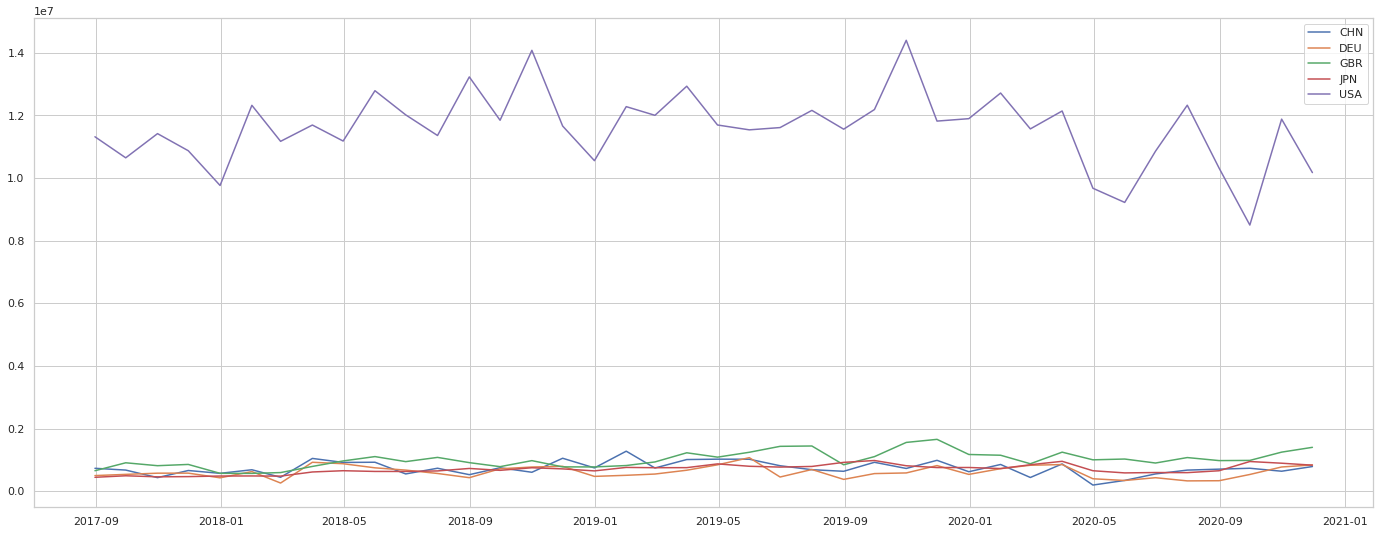

In [187]:
# plot the example time series
fig, ax = plt.subplots(figsize=(24,9))
import matplotlib.pyplot as plt
whole_data = train.copy()
target_label = target_column_name
whole_data[target_label] = train[target_column_name]
for g in whole_data.groupby(time_series_id_column_names):    
    plt.plot(g[1][time_column_name].values, g[1][target_column_name].values, label=g[0])
plt.legend()
plt.show()

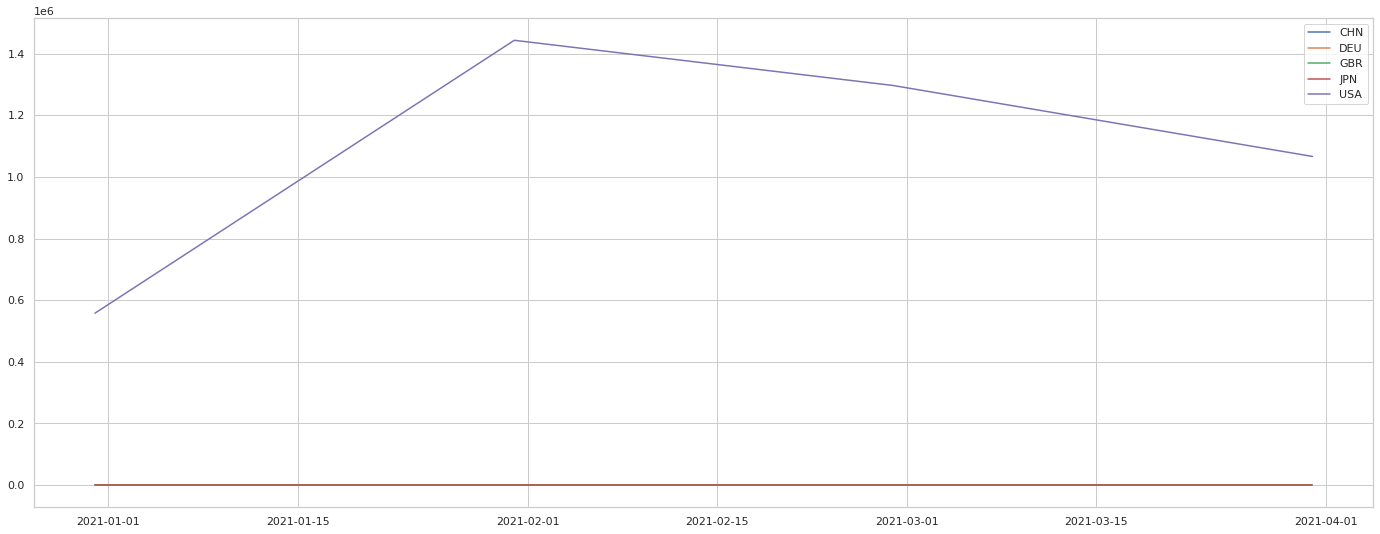

In [188]:
# plot the example time series
fig, ax = plt.subplots(figsize=(24,9))
import matplotlib.pyplot as plt
whole_data = test.copy()
target_label = target_column_name
whole_data[target_label] = test[target_column_name]
for g in whole_data.groupby(time_series_id_column_names):    
    plt.plot(g[1][time_column_name].values, g[1][target_column_name].values, label=g[0])
plt.legend()
plt.show()

In [189]:
datastore = ws.get_default_datastore()
datastore
datastore.upload_files(files = ['./revtime_train.csv', './revtime_test.csv'], target_path = 'merge_final/', overwrite = True,show_progress = True)

Uploading an estimated of 2 files
Uploading ./revtime_train.csv
Uploaded ./revtime_train.csv, 1 files out of an estimated total of 2
Uploading ./revtime_test.csv
Uploaded ./revtime_test.csv, 2 files out of an estimated total of 2
Uploaded 2 files


$AZUREML_DATAREFERENCE_42e082b5d8aa400da1143f23968ca0f1

In [190]:
#Create dataset for training
from azureml.core.dataset import Dataset
train_dataset = Dataset.Tabular.from_delimited_files(path=datastore.path('merge_final/revtime_train.csv'))

train_dataset.to_pandas_dataframe().tail()

,End_of_Month,Fin_Entity_ID,Revenue,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend,Total_Headcount,sp500,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline
195,2020-07-31,USA,12328340,16159400,11213216,-5,123012935,443,3271.12,0,0,0,0,0,0,10803182,10803182,10803182,10803182,10803182,10723370,10746035,11370337,9530404,10970026,9176408,6033241,3553548,2732948,1171828,1007203
196,2020-08-31,USA,10320678,33327484,7371988,-4,134997377,441,3500.31,0,0,0,0,0,0,0,11169048,11169048,11169048,11169048,11206453,11672759,11729005,12077379,8493856,9990264,7088390,4580338,2527116,1950590,736634
197,2020-09-30,USA,8500080,27723750,8118021,-3,94314941,451,3363.00,0,0,0,0,0,0,0,0,10383034,10383034,10383034,10275729,10769046,11687345,11370548,10514481,7249941,8275665,5187956,3336708,1797348,1451754
198,2020-10-31,USA,11883471,30715109,13538229,-2,98765729,443,3269.96,0,0,0,0,0,0,0,0,0,10234745,10234745,10292240,10168780,10530610,10879828,10175057,9341432,6561153,6987487,3790233,2550739,1421475
199,2020-11-30,USA,10175727,13478001,7312301,-1,137186318,438,3621.63,0,0,0,0,0,0,0,0,0,0,10186428,10230980,10630451,9695061,9452104,8732718,7584723,7436434,5664690,5869449,2731733,1975494


In [191]:
#Modeling

In [192]:
#Featurization Customization examples
featurization_config = FeaturizationConfig()
featurization_config.drop_columns = ['Monthly_Return','sp500_1M_Previous']  
# Force the CPWVOL5 feature to be numeric type.
#featurization_config.add_column_purpose('CPWVOL5', 'Numeric')
# Fill missing values in the target column, Revenue, with zeros.
featurization_config.add_transformer_params('Imputer', [target_column_name], {"strategy": "constant", "fill_value": 0})
# Fill missing values in the Current Opp Period Value column with median value.
featurization_config.add_transformer_params('Imputer', ['Current_Opp._Period_Value'], {"strategy": "median"})
featurization_config.add_transformer_params('Imputer', ['Conversions'], {"strategy": "median"})
# Fill missing values in the sp500 column with forward fill (last value carried forward).
featurization_config.add_transformer_params('Imputer', ['sp500'], {"strategy": "ffill"})
featurization_config.add_transformer_params('Imputer', ['Headcount'], {"strategy": "ffill"})
featurization_config.add_transformer_params('Imputer', ['Headcount_Contingent'], {"strategy": "ffill"})

In [193]:
# Train
from azureml.automl.core.forecasting_parameters import ForecastingParameters
lags = 'auto'#[x for x in range(1,7)]
print('lags: ',lags)
window_size = 'auto'
forecast_horizon = n_test_periods
print('window_size: ',window_size,' forecast_horizon: ',forecast_horizon)
forecasting_parameters = ForecastingParameters(
    time_column_name=time_column_name,
    forecast_horizon=forecast_horizon,
    time_series_id_column_names=time_series_id_column_names,
    target_lags=lags,
    feature_lags = 'auto',
    target_rolling_window_size=window_size,
    drop_column_names = ['-1M Pipeline']
)

automl_config = AutoMLConfig(task='forecasting',
                             debug_log='automl_revtime_errors.log',
                             primary_metric='normalized_root_mean_squared_error',
                             experiment_timeout_hours=4,
                             training_data=train_dataset,
                             label_column_name=target_column_name,
                             compute_target=compute_target,
                             #enable_early_stopping=True,
                             featurization='auto',#featurization_config,
                             n_cross_validations=5,
                             verbosity=logging.INFO,                             
                             max_concurrent_iterations=4,
                             max_cores_per_iteration=-1,
                             enable_dnn=True,
                             forecasting_parameters=forecasting_parameters)

lags:  auto
window_size:  auto  forecast_horizon:  4


In [194]:
#submit a new training run
remote_run = experiment.submit(automl_config, show_output=True)
remote_run

Running on remote.
Running on remote compute: cibimldev01
Parent Run ID: AutoML_00a0bb46-92cb-4c0c-b487-b34cebaf53f1


ERROR: Setup iteration failed: Unidentified error, check logs in portal / compute


Experiment,Id,Type,Status,Details Page,Docs Page
revenue-time-forecast,AutoML_00a0bb46-92cb-4c0c-b487-b34cebaf53f1,automl,Failed,Link to Azure Machine Learning studio,Link to Documentation


In [159]:
# If you need to retrieve a run that already started, use the following code
#from azureml.train.automl.run import AutoMLRun
#remote_run = AutoMLRun(experiment = experiment, run_id = 'AutoML_42189d9e-3b8d-47f2-adc4-30a3a27e4886')

In [160]:
remote_run.wait_for_completion()

{'runId': 'AutoML_c66ce873-e757-4a2e-ba84-5d38c3ec7c40',
 'target': 'cibimldev01',
 'status': 'Failed',
 'startTimeUtc': '2020-12-15T01:48:14.14819Z',
 'endTimeUtc': '2020-12-15T01:48:15.713872Z',
 'error': {'error': {'code': 'UserError',
   'message': 'AzureMLCompute cluster cibimldev01 has an error with code DiskFull that prevents it from scaling to 1 nodes. Message: ComputeNode.Id=tvmps_b25d577df368f87a5bcf0e56eb5af19a0db2f48f8f5be9ca5e59e163cbdfbd7e_d: There is not enough disk space on the node',
   'messageFormat': 'AzureMLCompute cluster {ClusterName} has an error with code {Code} that prevents it from scaling to {NodeCount} nodes. Message: {Message}',
   'messageParameters': {'ClusterName': 'cibimldev01',
    'Code': 'DiskFull',
    'NodeCount': '1',
    'Message': 'ComputeNode.Id=tvmps_b25d577df368f87a5bcf0e56eb5af19a0db2f48f8f5be9ca5e59e163cbdfbd7e_d: There is not enough disk space on the node'},
   'details': [],
   'innerError': {'code': 'BadArgument',
    'innerError': {'co

In [161]:
#Retrieve the Best Model
best_run, fitted_model = remote_run.get_output()
print("Best Run Model: ", best_run)
print(fitted_model.steps)
model_name = best_run.properties['model_name']
print("Model Name: ", model_name)

AutoMLException: AutoMLException:
	Message: Could not find a model with valid score for metric 'normalized_root_mean_squared_error'. Please ensure that at least one run was successfully completed with a valid score for the given metric.
	InnerException: None
	ErrorResponse 
{
    "error": {
        "code": "UserError",
        "message": "Could not find a model with valid score for metric 'normalized_root_mean_squared_error'. Please ensure that at least one run was successfully completed with a valid score for the given metric.",
        "target": "metric",
        "inner_error": {
            "code": "NotFound",
            "inner_error": {
                "code": "ModelMissing"
            }
        }
    }
}

In [ ]:
#Transparency
#View updated featurization summary
featurization_summary = fitted_model.named_steps['timeseriestransformer'].get_featurization_summary()
# View the featurization summary as a pandas dataframe
pd.DataFrame.from_records(featurization_summary)

In [ ]:
#Explore the results
from azureml.widgets import RunDetails
RunDetails(best_run).show()

In [ ]:
#FORECASTING
X_test = test.copy()
y_test = X_test.pop(target_column_name).values

In [ ]:
X_test.tail()

In [ ]:
# forecast returns the predictions and the featurized data, aligned to X_test.
# This contains the assumptions that were made in the forecast
# The featurized data, aligned to y, will also be returned.
# This contains the assumptions that were made in the forecast
# and helps align the forecast to the original data
y_predictions, X_trans = fitted_model.forecast(X_test)

In [ ]:
#from forecasting_helper import align_outputs

df_all = align_outputs(y_predictions, X_trans, X_test, y_test)
df_all

In [ ]:
#Evaluate
#To evaluate the accuracy of the forecast, we'll compare against the actual sales quantities for some select metrics, included the mean absolute percentage error (MAPE).

#We'll add predictions and actuals into a single dataframe for convenience in calculating the metrics.

#assign_dict = {'predicted': y_predictions, target_column_name: y_test}
#df_all = X_test.assign(**assign_dict)
#df_all

In [ ]:
from azureml.automl.core.shared import constants
from azureml.automl.runtime.shared.score import scoring
from matplotlib import pyplot as plt

# use automl scoring module
scores = scoring.score_regression(
    y_test=df_all[target_column_name],
    y_pred=df_all['predicted'],
    metrics=list(constants.Metric.SCALAR_REGRESSION_SET))

print("[Test data scores]\n")
for key, value in scores.items():    
    print('{}:   {:.3f}'.format(key, value))
    
# Plot outputs
%matplotlib inline
test_pred = plt.scatter(df_all[target_column_name], df_all['predicted'], color='b')
test_test = plt.scatter(df_all[target_column_name], df_all[target_column_name], color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

In [ ]:
#Confidence intervals
quantiles =  fitted_model.forecast_quantiles(X_test)
quantiles

In [ ]:
# specify which quantiles you would like 
fitted_model.quantiles = [0.01, 0.5, 0.8, 0.95]
# use forecast_quantiles function, not the forecast() one
y_pred_quantiles =  fitted_model.forecast_quantiles(X_test)

# quantile forecasts returned in a Dataframe along with the time and time series id columns 
y_pred_quantiles

In [ ]:
#Get the column index list in the right order
cols_sort_list = list(df_all.columns) + ['Revenue_Forecast']
display(cols_sort_list)
display(df_all)

In [ ]:
#Merge df_all with train
from functools import reduce
nan_value = 0
merge_dfs = [train, df_all]

final_merge_df = train.append(df_all, ignore_index=True).sort_values(by=sort_list)
coerce_df_columns_to_numeric(final_merge_df)

final_merge_df = final_merge_df.replace(np.nan, 0, regex=True)
#merge_df = merge_df.query('Fin_Entity_ID!="SGP"') # Exclude Singapore rows
#final_merge_df.sort_values(by=['Relative_Offset','Fin_Entity_ID']).reset_index(drop=True) and Relative_Month_Offset >= 0
#merge_df.drop(columns=['Current_Opp._Period_Value','Conversions'], axis=1, inplace = True)
#create new column
final_merge_df['Revenue_Forecast'] = np.where(final_merge_df['predicted']!=0, final_merge_df['predicted'], final_merge_df['Revenue'])
final_merge_df['Relative_Month_Offset'] = round((final_merge_df['End_of_Month'] - current_eom)/np.timedelta64(1,'M'),0).astype(int)
final_merge_df['End_of_Month'] = pd.to_datetime(final_merge_df['End_of_Month']).dt.date
final_merge_df['origin'] = pd.to_datetime(final_merge_df['origin']).dt.date
#inal_merge_df['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df['Snapshot_Date_Short'])
final_merge_df = final_merge_df.sort_values(by=sort_list).reset_index(drop=True)
final_merge_df = final_merge_df.reindex(columns=cols_sort_list) #sort using original cols_sort_list
print("\n final_merge_df: \n")
final_merge_df.to_csv("final_merge_df.csv", index=False)
show_stats(merge_df)
final_merge_df.query('Fin_Entity_ID==@entity_debug')

In [ ]:
#pivot by EOM1, Fin_Entity_ID
final_merge_pivot1 = final_merge_df.pivot_table(index=['End_of_Month','Relative_Month_Offset'], 
                                                columns='Fin_Entity_ID', 
                                                values='Revenue_Forecast', aggfunc=np.sum, margins=True)
final_merge_pivot1 = final_merge_pivot1.reset_index(level=final_merge_pivot1.index.names)
#final_merge_pivot1['End_of_Month'] = pd.to_datetime(final_merge_pivot1['End_of_Month']).dt.date
#show_stats(revtime_pivot1)
final_merge_pivot1#.query('(End_of_Month == @current_eom)')

In [ ]:
# multiple line plot
#Set themes
import matplotlib.pyplot as plt
#plot
sns.set()
sns.set_context("poster") #In order of relative size they are: paper, notebook, talk, and poster. Notebook is default
sns.set(style="whitegrid") #Seaborn has five built-in themes to style its plots: darkgrid, whitegrid, dark, white, and ticks. 
# Save a palette to a variable:
palette = sns.color_palette("Accent",8)
# Use palplot and pass in the variable:
#sns.palplot(palette)
# Set the palette using the name of a palette:
#sns.set_palette(palette)

In [ ]:
#Bar plot for history and forecast revenues summary by month
fig, ax = plt.subplots(figsize=(24,9))
div_by_thousand = 1000
div_by_mil = 1000000
final_merge_df1 =final_merge_df.pivot_table(index=['End_of_Month','Relative_Month_Offset'], 
                                                #columns='Fin_Entity_ID', 
                                                values='Revenue_Forecast', aggfunc=np.sum, margins=False)
final_merge_df1 = final_merge_df1.reset_index(level=final_merge_df1.index.names)
final_merge_df1['Date'] = pd.to_datetime(final_merge_df1['End_of_Month']).dt.date#.astype(str)
final_merge_df1['Revenue_Forecast'] = round(final_merge_df1['Revenue_Forecast']/div_by_mil,4)
values = final_merge_df1['Relative_Month_Offset'].unique()
clrs = ['grey' if (x < 0) else 'g' for x in values ]
#revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)
g = sns.barplot(x="Date", y="Revenue_Forecast", ci=None,
                data=final_merge_df1,
                palette=clrs, #alpha=0.50,
                ax=ax
               )
plt.xticks(rotation=90)
plt.title("Revenue & Forecast by Month (in Millions)",fontsize =18)
for p in g.patches:
    g.annotate("{:,.1f}".format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
g.legend(['Revenue','Forecast'], facecolor='w')
plt.show()

In [ ]:
div_by_thousand = 1000
div_by_mil = 1000000
final_merge_df1 = final_merge_df.copy()
final_merge_df1['Revenue_Forecast'] = round(final_merge_df1['Revenue_Forecast']/div_by_mil,4)
values = final_merge_df1['Relative_Month_Offset'].unique()
clrs = ['grey' if (x < 0) else 'g' for x in values ]
g = sns.FacetGrid(data=final_merge_df1,
                  col="Fin_Entity_ID",
                  height=8,
                  aspect=2.5,
                  col_wrap=1
                  #palette=clrs, #alpha=0.50
               )
g.map_dataframe(sns.barplot, "End_of_Month", "Revenue_Forecast", palette=clrs)
for ax in g.axes.ravel():
  for p in ax.patches:
    ax.annotate("{:,.2f}".format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
g.set_xticklabels(rotation=90)
plt.title("Revenue & Forecast by Month (in Millions)",fontsize =18)
plt.show()

In [ ]:
Regression Analysis *****************************************************************************************************************
reg_target_column_name = 'Revenue_Forecast'
reg_df = pd.read_csv("final_merge_df.csv", parse_dates=[time_column_name])
all_cols = reg_df.columns
display(all_cols)
columns_to_remove = ["origin", "predicted", "horizon_origin", "Current_Opp._Period_Value", "Conversions", "Pipeline_Trend", "Total_Headcount",
                     "sp500", "Revenue"
                    ]
for col in columns_to_remove:
    reg_df.pop(col)

display(reg_df.head(5))
display(reg_df.tail(5))

In [ ]:
reg_df.describe().T

In [ ]:
# Get Merge_Final and remove other cols
reg_df1 = merge_final.copy()
all_cols1 = reg_df1.columns
display(all_cols1)
columns_to_remove1 = ["Current_Opp._Period_Value", "Conversions", "Pipeline_Trend", "Total_Headcount",
                     "sp500", "Revenue"
                    ]
for col in columns_to_remove1:
    reg_df1.pop(col)

display(reg_df1.head(5))
display(reg_df1.tail(5))

In [58]:
reg_merge_final = pd.merge(reg_df, reg_df1, how='left', on=['End_of_Month','Relative_Month_Offset','Fin_Entity_ID'])
coerce_df_columns_to_numeric(reg_merge_final)
reg_merge_final = reg_merge_final.replace(np.nan, 0, regex=True)
reg_merge_final = reg_merge_final.sort_values(by=['End_of_Month','Relative_Month_Offset','Fin_Entity_ID']).reset_index(drop=True)
print("\n reg_merge_final: \n")
reg_merge_final.to_csv("reg_merge_final.csv", index=False)
show_stats(reg_merge_final)
reg_merge_final.query('Fin_Entity_ID==@entity_debug')


 reg_merge_final: 


 DF Name: 



'reg_merge_final'


 DF Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 26 columns):
End_of_Month             265 non-null datetime64[ns]
Fin_Entity_ID            265 non-null object
Relative_Month_Offset    265 non-null int64
Revenue_Forecast         265 non-null int64
-11M Pipeline            265 non-null int64
-10M Pipeline            265 non-null int64
-9M Pipeline             265 non-null int64
-8M Pipeline             265 non-null int64
-7M Pipeline             265 non-null int64
-6M Pipeline             265 non-null int64
-5M Pipeline             265 non-null int64
-4M Pipeline             265 non-null int64
-3M Pipeline             265 non-null int64
-2M Pipeline             265 non-null int64
-1M Pipeline             265 non-null int64
0M Pipeline              265 non-null int64
1M Pipeline              265 non-null int64
2M Pipeline              265 non-null int64
3M Pipeline              265 non-null int64
4M Pipeline              265 non-nul

None


 DF Describe: 



,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
End_of_Month,265,53,2017-11-30 00:00:00,5,2017-01-31,2021-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fin_Entity_ID,265,5,GBR,53,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Month_Offset,265.00,NaN,NaN,NaN,NaT,NaT,-21.00,15.33,-47.00,-34.00,-21.00,-8.00,5.00
Revenue_Forecast,265.00,NaN,NaN,NaN,NaT,NaT,2837495.72,4255015.74,195142.00,594053.00,773985.00,1103362.00,14401673.00
-11M Pipeline,265.00,NaN,NaN,NaN,NaT,NaT,1694742.65,3686399.28,0.00,0.00,527301.00,842942.00,14401673.00



 DF Head: 



,End_of_Month,Fin_Entity_ID,Relative_Month_Offset,Revenue_Forecast,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline
0,2017-01-31,CHN,-47,639967,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2017-01-31,DEU,-47,515289,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2017-01-31,GBR,-47,640653,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2017-01-31,JPN,-47,329393,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2017-01-31,USA,-47,10671035,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



 DF Tail: 



,End_of_Month,Fin_Entity_ID,Relative_Month_Offset,Revenue_Forecast,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline
260,2021-05-31,CHN,5,592616,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,411189,304961,117114,97549,10040,0
261,2021-05-31,DEU,5,589923,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,198134,201214,163439,12988,0,36394
262,2021-05-31,GBR,5,1007868,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,362806,365825,145530,90668,0,0
263,2021-05-31,JPN,5,672917,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,108485,108485,49941,35530,14157,0
264,2021-05-31,USA,5,9764038,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3174454,2320056,1855801,1031585,821161,636998



 Entity Sum: 



,Fin_Entity_ID,Relative_Month_Offset,Revenue_Forecast,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline
0,CHN,-1113,37866606,23348740,23055326,23251581,23013931,22697564,22678715,22667698,22927643,22613540,22332828,22192375,22033624,23761783,22397587,16013372,11663176,8704651,6494084,4473972,2986389,1887312,1405965
1,DEU,-1113,32033409,18836917,19166367,19480074,19301957,19067289,19070758,18773582,18847954,18458242,18354120,18446375,18164465,20448147,19632170,15096024,10160376,7431870,5876785,4250153,2833199,1954645,1620111
2,GBR,-1113,51210805,29724065,29946803,30286304,30473932,30646499,30975926,31481759,31882273,32074478,32355631,32649878,31668396,32846534,33277018,28941124,22367212,16529402,12452286,8853710,6161701,3931443,2421716
3,JPN,-1113,34576451,20409938,20810969,21273056,21467354,21585872,21697548,21803565,21974139,22308397,22547955,22748119,22875977,24396774,21854285,15873769,9644313,6019510,4135621,2597351,1525160,947868,610305
4,USA,-1113,596249096,356787142,357038321,358533767,356788803,355137655,356231422,356234845,355364532,352169580,352869350,350346781,333978390,393977660,378213773,309462384,220737762,148089041,101713145,69473378,44958865,30318811,19628567



 Studio Count: 



,Fin_Entity_ID,End_of_Month,Relative_Month_Offset,Revenue_Forecast,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline
0,CHN,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53
1,DEU,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53
2,GBR,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53
3,JPN,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53
4,USA,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53



 EOM Sum:


,End_of_Month,Relative_Month_Offset,Revenue_Forecast,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline
0,2017-01-31,-235,12796337,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2017-02-28,-230,12476757,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2017-03-31,-225,14191127,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2017-04-30,-220,12449452,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2017-05-31,-215,13669410,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



 EOM Count: 



,End_of_Month,Fin_Entity_ID,Relative_Month_Offset,Revenue_Forecast,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline
0,2017-01-31,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
1,2017-02-28,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
2,2017-03-31,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
3,2017-04-30,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
4,2017-05-31,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5


,End_of_Month,Fin_Entity_ID,Relative_Month_Offset,Revenue_Forecast,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline
2,2017-01-31,GBR,-47,640653,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,2017-02-28,GBR,-46,686520,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,2017-03-31,GBR,-45,695914,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17,2017-04-30,GBR,-44,620690,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22,2017-05-31,GBR,-43,480997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27,2017-06-30,GBR,-42,613119,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32,2017-07-31,GBR,-41,924330,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
37,2017-08-31,GBR,-40,652908,652908,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42,2017-09-30,GBR,-39,906711,906711,906711,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
47,2017-10-31,GBR,-38,813818,813818,813818,813818,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [59]:
from sklearn.model_selection import train_test_split
full_final_df = reg_merge_final.copy()

past_final_df = full_final_df.query('Relative_Month_Offset < 0')
future_final_df = full_final_df.query('Relative_Month_Offset >= 0')
display(past_final_df.tail())
display(future_final_df.head())

,End_of_Month,Fin_Entity_ID,Relative_Month_Offset,Revenue_Forecast,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline
230,2020-11-30,CHN,-1,786755,0,0,0,0,0,0,0,0,0,0,786755,784699,1255299,1142895,655223,474136,223240,122168,78373,81921,412715,258873
231,2020-11-30,DEU,-1,837967,0,0,0,0,0,0,0,0,0,0,837967,827396,770618,804377,452222,484614,367933,254884,254518,87093,66795,56587
232,2020-11-30,GBR,-1,1400238,0,0,0,0,0,0,0,0,0,0,1400238,1393327,1315058,806165,713727,542126,661642,577462,547686,519476,557803,513874
233,2020-11-30,JPN,-1,830642,0,0,0,0,0,0,0,0,0,0,830642,827058,804414,346498,395711,233741,257811,72236,44627,63681,161339,7854
234,2020-11-30,USA,-1,10175727,0,0,0,0,0,0,0,0,0,0,10175729,10309386,11335315,8899525,7197377,5629916,4400992,4897742,4087145,4087034,1756028,1486370


,End_of_Month,Fin_Entity_ID,Relative_Month_Offset,Revenue_Forecast,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline
235,2020-12-31,CHN,0,591905,0,0,0,0,0,0,0,0,0,0,0,825103,655739,655224,833038,590557,389525,192416,59215,12888,0,381809
236,2020-12-31,DEU,0,585662,0,0,0,0,0,0,0,0,0,0,0,586067,596125,556475,462486,269140,403007,269394,260823,215235,48548,49514
237,2020-12-31,GBR,0,1068295,0,0,0,0,0,0,0,0,0,0,0,889383,949769,844885,476919,321615,361927,480275,383552,354284,351461,371869
238,2020-12-31,JPN,0,671614,0,0,0,0,0,0,0,0,0,0,0,645943,468668,375678,275668,280483,273851,267829,45069,46101,63084,115126
239,2020-12-31,USA,0,9651816,0,0,0,0,0,0,0,0,0,0,0,9972140,9921094,10216181,6436844,4639716,3635890,3645987,3544811,2967330,3303201,1424520


In [97]:
#Split the data into train and test sets
#split for Relative_Month_Offset < 0 i.e. less than current month to prepare model using actual values using pipeline
x_train, x_test = train_test_split(full_final_df, test_size=0.2, random_state=223)
print('x_train, x_test with full_final_df')
display(x_train.tail())
display(x_test.head())
#Split for full dataset
# Split the dataset into train and test datasets
#dataset = Dataset.Tabular(full_final_df)
#train_data, test_data = dataset.random_split(percentage=0.8, seed=223)
train_data, test_data = train_test_split(full_final_df, test_size=0.2, random_state=223)
print('\n\ntrain_data, test_data with full_final_df')
display(train_data.count())
display(test_data.count())

x_train, x_test with full_final_df


,End_of_Month,Fin_Entity_ID,Relative_Month_Offset,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline
158,2019-08-31,JPN,-16,919965,919965,919965,919965,919965,919965,919965,919965,919965,919965,919965,924318,1028784,436568,464438,166878,8061,0,0,0,0,0
175,2019-12-31,CHN,-12,620791,620791,620791,620791,620791,620791,620791,620791,620791,620791,620791,638672,703677,759947,606877,482502,207603,261281,123723,104489,87678,0
111,2018-11-30,DEU,-25,793416,793416,793416,793416,793416,793416,793416,793416,793416,793416,793416,824987,1223623,1145263,689042,264506,0,0,0,0,0,0
190,2020-03-31,CHN,-9,0,0,870103,870103,870103,870103,870103,870103,870103,870103,870103,870966,696252,744585,816258,797486,280749,301347,173658,0,0,0
17,2017-04-30,GBR,-44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,End_of_Month,Fin_Entity_ID,Relative_Month_Offset,-11M Pipeline,-10M Pipeline,-9M Pipeline,-8M Pipeline,-7M Pipeline,-6M Pipeline,-5M Pipeline,-4M Pipeline,-3M Pipeline,-2M Pipeline,-1M Pipeline,0M Pipeline,1M Pipeline,2M Pipeline,3M Pipeline,4M Pipeline,5M Pipeline,6M Pipeline,7M Pipeline,8M Pipeline,9M Pipeline,10M Pipeline
59,2017-12-31,USA,-36,9764359,9764359,9764359,9764358,9764358,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
227,2020-10-31,GBR,-2,0,0,0,0,0,0,0,0,0,1247034,1247034,1247301,1173623,1004127,715171,754200,606358,592411,546383,584365,554607,553499
41,2017-09-30,DEU,-39,536501,536501,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
35,2017-08-31,CHN,-40,730547,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
62,2018-01-31,GBR,-35,567708,567708,567708,567708,567708,567708,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0




train_data, test_data with full_final_df


End_of_Month             212
Fin_Entity_ID            212
Relative_Month_Offset    212
-11M Pipeline            212
-10M Pipeline            212
-9M Pipeline             212
-8M Pipeline             212
-7M Pipeline             212
-6M Pipeline             212
-5M Pipeline             212
-4M Pipeline             212
-3M Pipeline             212
-2M Pipeline             212
-1M Pipeline             212
0M Pipeline              212
1M Pipeline              212
2M Pipeline              212
3M Pipeline              212
4M Pipeline              212
5M Pipeline              212
6M Pipeline              212
7M Pipeline              212
8M Pipeline              212
9M Pipeline              212
10M Pipeline             212
dtype: int64

End_of_Month             53
Fin_Entity_ID            53
Relative_Month_Offset    53
-11M Pipeline            53
-10M Pipeline            53
-9M Pipeline             53
-8M Pipeline             53
-7M Pipeline             53
-6M Pipeline             53
-5M Pipeline             53
-4M Pipeline             53
-3M Pipeline             53
-2M Pipeline             53
-1M Pipeline             53
0M Pipeline              53
1M Pipeline              53
2M Pipeline              53
3M Pipeline              53
4M Pipeline              53
5M Pipeline              53
6M Pipeline              53
7M Pipeline              53
8M Pipeline              53
9M Pipeline              53
10M Pipeline             53
dtype: int64

In [98]:
#Configure workspace
#create an Experiment. An Experiment corresponds to a prediction problem you are trying to solve, while a Run corresponds to a specific approach to the problem.
from azureml.core.experiment import Experiment

ws = Workspace.from_config()
# choose a name for the run history container in the workspace
experiment_name = 'revenue-regression'

experiment = Experiment(ws, experiment_name)

output = {}
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['SKU'] = ws.sku
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
Subscription ID,db61fd47-db56-45e3-844f-1b1f5c47990a
Workspace,dwmlazwu01
SKU,Enterprise
Resource Group,BI-DevQA-RG
Location,westus2
Run History Name,revenue-regression


In [99]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
cpu_cluster_name = "cibimldev01"

# Verify that cluster does not exist already
compute_target = ComputeTarget(workspace=ws, name=cpu_cluster_name)
print('Found existing cluster, use it.',compute_target)

Found existing cluster, use it. {
  "Name": "cibimldev01",
  "Id": "/subscriptions/db61fd47-db56-45e3-844f-1b1f5c47990a/resourceGroups/BI-DevQA-RG/providers/Microsoft.MachineLearningServices/workspaces/dwmlazwu01/computes/cibimldev01",
  "Workspace": "dwmlazwu01",
  "Location": "westus2",
  "VmSize": "STANDARD_D4_V3",
  "State": "Running",
  "Tags": null
}


In [100]:
#Define training settings
import logging

automl_settings = {
    "iteration_timeout_minutes": 10,
    "experiment_timeout_hours": 3,
    "enable_early_stopping": False,
    "primary_metric": 'spearman_correlation',
    "featurization": 'auto',
    "max_concurrent_iterations": 4,
    "max_cores_per_iteration": -1,
    "verbosity": logging.INFO,
    "n_cross_validations": 5,
    "enable_dnn": True
}

In [103]:
#Train the automatic regression model
from azureml.train.automl import AutoMLConfig

automl_config = AutoMLConfig(task='regression',
                             #compute_target = compute_target,
                             debug_log='automated_ml_errors.log',
                             training_data=train_data,                             
                             label_column_name=reg_target_column_name,
                             **automl_settings)

In [104]:
from azureml.core.experiment import Experiment
experiment = Experiment(ws, experiment_name)
local_run = experiment.submit(automl_config, show_output=True)

Running on local machine


DataException: DataException:
	Message: Expected column(s) Revenue_Forecast not found in X.
	InnerException: None
	ErrorResponse 
{
    "error": {
        "code": "UserError",
        "message": "Expected column(s) Revenue_Forecast not found in X.",
        "target": "X",
        "inner_error": {
            "code": "BadArgument",
            "inner_error": {
                "code": "MissingColumnsInData"
            }
        }
    }
}

In [ ]:
# If you need to retrieve a run that already started, use the following code
#from azureml.train.automl.run import AutoMLRun
#local_run = AutoMLRun(experiment = experiment, run_id = 'AutoML_e9d32bf2-1a54-4aa5-b05f-11a3ad7122e1')

In [105]:
# Explore the results
from azureml.widgets import RunDetails
RunDetails(local_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [106]:
local_run.wait_for_completion()

{'runId': 'AutoML_e9d32bf2-1a54-4aa5-b05f-11a3ad7122e1',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2020-12-13T15:13:54.749713Z',
 'endTimeUtc': '2020-12-13T18:19:21.863676Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'spearman_correlation',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '5',
  'target': 'local',
  'AMLSettingsJsonString': '{"path":null,"name":"revenue-regression","subscription_id":"db61fd47-db56-45e3-844f-1b1f5c47990a","resource_group":"BI-DevQA-RG","workspace_name":"dwmlazwu01","region":"westus2","compute_target":"local","spark_service":null,"azure_service":"Microsoft.AzureNotebookVM","_local_managed_run_id":null,"many_models":false,"pipeline_fetch_max_batch_size":1,"iterations":1000,"primary_metric":"spearman_correlation","task_type":"regression","data_script":null,"validation_size":0.0,"n_cross_validations":5,"y_min":null,"y_max":n

In [107]:
#Retrieve the best model
best_run, fitted_model = local_run.get_output()
print(best_run)
print(fitted_model)

Run(Experiment: revenue-regression,
Id: AutoML_e9d32bf2-1a54-4aa5-b05f-11a3ad7122e1_363,
Type: None,
Status: Completed)
RegressionPipeline(pipeline=Pipeline(memory=None,
                                     steps=[('datatransformer',
                                             DataTransformer(enable_dnn=None,
                                                             enable_feature_sweeping=None,
                                                             feature_sweeping_config=None,
                                                             feature_sweeping_timeout=None,
                                                             featurization_config=None,
                                                             force_text_dnn=None,
                                                             is_cross_validation=None,
                                                             is_onnx_compatible=None,
                                                             logger=Non

In [108]:
#Automated feature engineering
#View updated featurization summary
featurization_summary = fitted_model.named_steps['datatransformer'].get_featurization_summary()
# View the featurization summary as a pandas dataframe
pd.DataFrame.from_records(featurization_summary)

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations
0,-10M Pipeline,Numeric,No,1,[MeanImputer]
1,-11M Pipeline,Numeric,No,1,[MeanImputer]
2,-1M Pipeline,Numeric,No,1,[MeanImputer]
3,-2M Pipeline,Numeric,No,1,[MeanImputer]
4,-3M Pipeline,Numeric,No,1,[MeanImputer]
5,-4M Pipeline,Numeric,No,1,[MeanImputer]
6,-5M Pipeline,Numeric,No,1,[MeanImputer]
7,-6M Pipeline,Numeric,No,1,[MeanImputer]
8,-7M Pipeline,Numeric,No,1,[MeanImputer]
9,-8M Pipeline,Numeric,No,1,[MeanImputer]


In [109]:
#Test the best model accuracy
y_test = x_test.pop(reg_target_column_name)

y_predict = fitted_model.predict(x_test)
print(y_predict[:10])

KeyError: 'Revenue_Forecast'

In [71]:
from sklearn.metrics import mean_squared_error
from math import sqrt

y_actual = y_test.values.flatten().tolist()
rmse = sqrt(mean_squared_error(y_actual, y_predict))
rmse

293356.39587912324

In [72]:
sum_actuals = sum_errors = 0

for actual_val, predict_val in zip(y_actual, y_predict):
    abs_error = actual_val - predict_val
    if abs_error < 0:
        abs_error = abs_error * -1

    sum_errors = sum_errors + abs_error
    sum_actuals = sum_actuals + actual_val

mean_abs_percent_error = sum_errors / sum_actuals
print("Model MAPE:")
print(mean_abs_percent_error)
print()
print("Model Accuracy:")
print(1 - mean_abs_percent_error)

Model MAPE:
0.036710587078351634

Model Accuracy:
0.9632894129216484


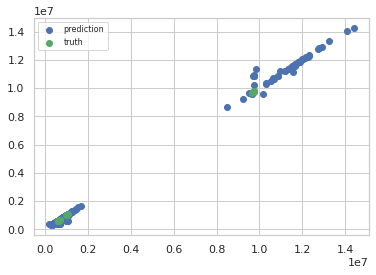

In [84]:
%matplotlib inline
test_pred = plt.scatter(y_actual, y_predict, color='b')
test_test = plt.scatter(y_test, y_test, color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

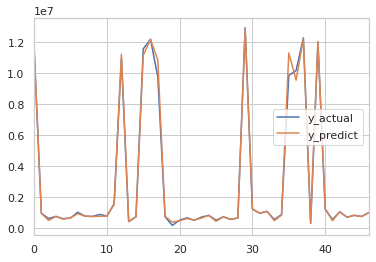

In [75]:
df=pd.DataFrame(zip(y_actual, y_predict), columns=['y_actual','y_predict'])
df.plot()

In [76]:
#Test the best model accuracy for full model
y_test = full_final_df.pop(reg_target_column_name)

y_predict = fitted_model.predict(full_final_df)
print(y_predict[:10])
from sklearn.metrics import mean_squared_error
from math import sqrt

y_actual = y_test.values.flatten().tolist()
rmse = sqrt(mean_squared_error(y_actual, y_predict))
rmse

[  643734.2285   517766.3566   644636.4861   333059.5218 10654598.3342   640974.3038   489787.7983   639243.3703
   348312.8871 10362690.4162]


206367.80261237003

In [77]:
sum_actuals = sum_errors = 0

df=pd.DataFrame(zip(y_actual, y_predict), columns=['y_actual','y_predict'])

for actual_val, predict_val in zip(y_actual, y_predict):
    abs_error = actual_val - predict_val
    if abs_error < 0:
        abs_error = abs_error * -1

    sum_errors = sum_errors + abs_error
    sum_actuals = sum_actuals + actual_val

mean_abs_percent_error = sum_errors / sum_actuals
print("Model MAPE:")
print(mean_abs_percent_error)
print()
print("Model Accuracy:")
print(1 - mean_abs_percent_error)

Model MAPE:
0.024109764439088452

Model Accuracy:
0.9758902355609116


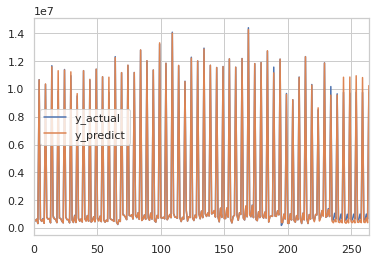

In [78]:
df.plot()

In [79]:
df

,y_actual,y_predict
0,639967,643734.23
1,515289,517766.36
2,640653,644636.49
3,329393,333059.52
4,10671035,10654598.33
...,...,...
260,592616,436861.94
261,589923,397970.60
262,1007868,737099.60
263,672917,392661.62


In [80]:
# TEST
# preview the first 3 rows of the dataset

test_data = future_final_df#.to_pandas_dataframe()
y_test = test_data[reg_target_column_name].fillna(0)
test_data = test_data.drop(reg_target_column_name, 1)
test_data = test_data.fillna(0)


train_data = past_final_df#.to_pandas_dataframe()
y_train = train_data[reg_target_column_name].fillna(0)
train_data = train_data.drop(reg_target_column_name, 1)
train_data = train_data.fillna(0)

In [81]:
y_pred_train = fitted_model.predict(train_data)
y_residual_train = y_train - y_pred_train

y_pred_test = fitted_model.predict(test_data)
y_residual_test = y_test - y_pred_test

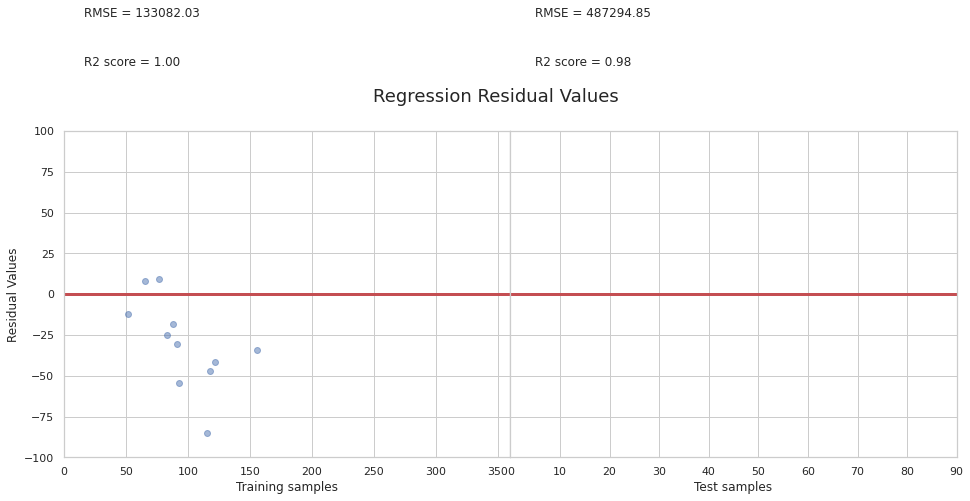

In [82]:
%matplotlib inline
from sklearn.metrics import mean_squared_error, r2_score

# Set up a multi-plot chart.
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw = {'width_ratios':[1, 1], 'wspace':0, 'hspace': 0})
f.suptitle('Regression Residual Values', fontsize = 18)
f.set_figheight(6)
f.set_figwidth(16)

# Plot residual values of training set.
a0.axis([0, 360, -100, 100])
a0.plot(y_residual_train, 'bo', alpha = 0.5)
a0.plot([-10,360],[0,0], 'r-', lw = 3)
a0.text(16,170,'RMSE = {0:.2f}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train))), fontsize = 12)
a0.text(16,140,'R2 score = {0:.2f}'.format(r2_score(y_train, y_pred_train)),fontsize = 12)
a0.set_xlabel('Training samples', fontsize = 12)
a0.set_ylabel('Residual Values', fontsize = 12)

# Plot residual values of test set.
a1.axis([0, 90, -100, 100])
a1.plot(y_residual_test, 'bo', alpha = 0.5)
a1.plot([-10,360],[0,0], 'r-', lw = 3)
a1.text(5,170,'RMSE = {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))), fontsize = 12)
a1.text(5,140,'R2 score = {0:.2f}'.format(r2_score(y_test, y_pred_test)),fontsize = 12)
a1.set_xlabel('Test samples', fontsize = 12)
a1.set_yticklabels([])

plt.show()

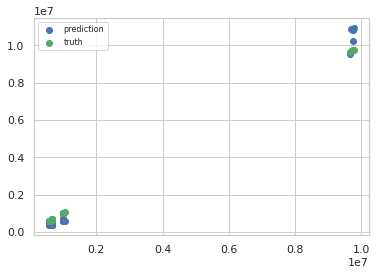

In [83]:
%matplotlib inline
test_pred = plt.scatter(y_test, y_pred_test, color='b')
test_test = plt.scatter(y_test, y_test, color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

AttributeError: 'PathCollection' object has no attribute 'pivot_table'

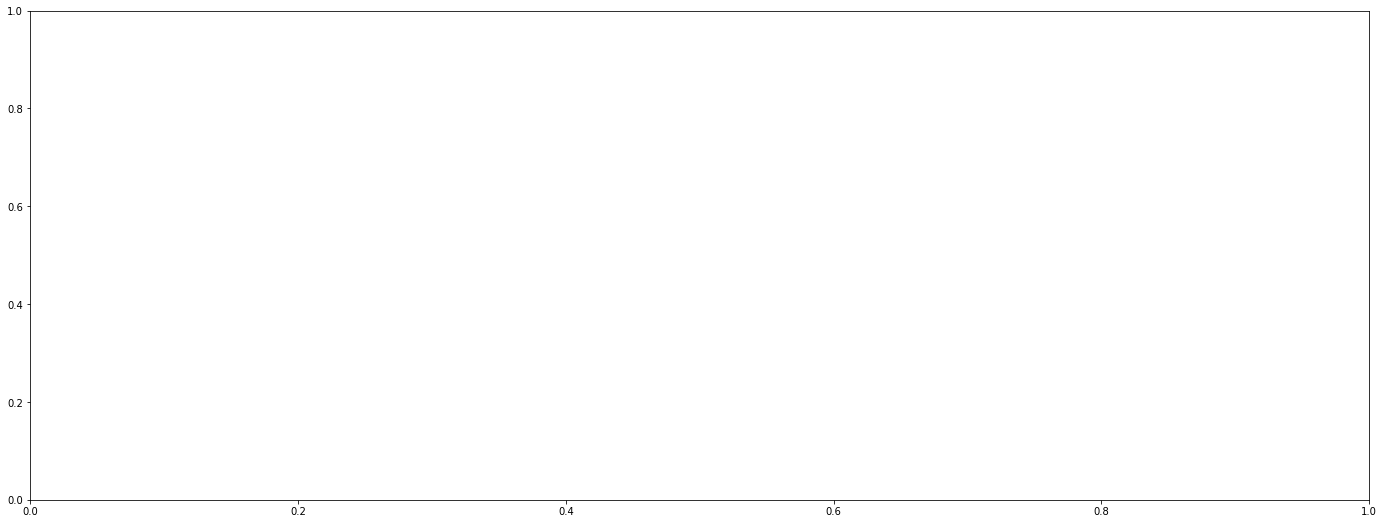

In [114]:
#Bar plot for history and forecast revenues summary by month
fig, ax = plt.subplots(figsize=(24,9))
div_by_thousand = 1000
div_by_mil = 1000000
test_pred1 =test_pred.pivot_table(index=['End_of_Month','Relative_Month_Offset'], 
                                                #columns='Fin_Entity_ID', 
                                                values='Revenue_Forecast', aggfunc=np.sum, margins=False)
test_pred1 = test_pred.reset_index(level=test_pred1.index.names)
test_pred1['Date'] = pd.to_datetime(test_pred1['End_of_Month']).dt.date#.astype(str)
test_pred1['Revenue_Forecast'] = round(test_pred1['Revenue_Forecast']/div_by_mil,4)
values = test_pred1['Relative_Month_Offset'].unique()
clrs = ['grey' if (x < 0) else 'g' for x in values ]
#revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)
g = sns.barplot(x="Date", y="Revenue_Forecast", ci=None,
                data=test_pred,
                palette=clrs, #alpha=0.50,
                ax=ax
               )
plt.xticks(rotation=90)
plt.title("Revenue & Forecast by Month (in Millions)",fontsize =18)
for p in g.patches:
    g.annotate("{:,.1f}".format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
g.legend(['Revenue','Forecast'], facecolor='w')
plt.show()

In [225]:
STOP*************************************************************

SyntaxError: invalid syntax (<ipython-input-225-212ce48f0d87>, line 1)

In [ ]:
Operationalize
#Operationalization means getting the model into the cloud so that other can run it after you close the notebook. We will create a docker running on Azure Container Instances with the model.
description = 'AutoML Revenue forecaster'
tags = None
model = remote_run.register_model(model_name = model_name, description = description, tags = tags)

print(remote_run.model_id)

In [ ]:
#Develop the scoring script
#For the deployment we need a function which will run the forecast on serialized data. It can be obtained from the best_run.
script_file_name = 'score_fcast.py'
best_run.download_file('outputs/scoring_file_v_1_0_0.py', script_file_name)

In [ ]:
#Deploy the model as a Web Service on Azure Container 
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model

inference_config = InferenceConfig(environment = best_run.get_environment(), 
                                   entry_script = script_file_name)

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 2, 
                                               tags = {'type': "automl-forecasting"},
                                               description = "Automl forecasting revenue service")

aci_service_name = 'automl-revenue-forecast-01'
print(aci_service_name)
aci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)
print(aci_service.state)

In [ ]:
aci_service.get_logs()

In [ ]:
#Call the service
import json
X_query = X_test.copy()
# We have to convert datetime to string, because Timestamps cannot be serialized to JSON.
X_query[time_column_name] = X_query[time_column_name].astype(str)
# The Service object accept the complex dictionary, which is internally converted to JSON string.
# The section 'data' contains the data frame in the form of dictionary.
test_sample = json.dumps({'data': X_query.to_dict(orient='records')})
response = aci_service.run(input_data = test_sample)
# translate from networkese to datascientese
try: 
    res_dict = json.loads(response)
    y_fcst_all = pd.DataFrame(res_dict['index'])
    y_fcst_all[time_column_name] = pd.to_datetime(y_fcst_all[time_column_name], unit = 'ms')
    y_fcst_all['forecast'] = res_dict['forecast']    
except:
    print(res_dict)

In [ ]:
y_fcst_all.head()

In [ ]:
#Delete the web service if desired
#serv = Webservice(ws, 'automl-revenue-forecast-01')
#serv.delete()     # don't do it accidentally

In [ ]:
STOP

In [ ]:
#Export revenue only for time series forecast
#cols = revhist1.columns
#revtime_hist = merge_df[cols].query('End_of_Month < @current_eom').reset_index(drop=True)
#revtime_hist = merge_final.query('End_of_Month < @current_eom').reset_index(drop=True)
#revtime_hist.to_csv("revtime_hist.csv", index=False)
#revtime_foreast = merge_final.query('End_of_Month >= @current_eom').reset_index(drop=True)
#revtime_foreast.drop(columns=['Revenue'], axis=1, inplace = True)
#revtime_foreast.to_csv("revtime_foreast.csv", index=False)

In [ ]:
#Plot dataset
sns.set()
sns.set_context("talk") #In order of relative size they are: paper, notebook, talk, and poster. Notebook is default
sns.set(style="whitegrid") #Seaborn has five built-in themes to style its plots: darkgrid, whitegrid, dark, white, and ticks. 
# Save a palette to a variable:
palette = sns.color_palette("Accent",8)
# Use palplot and pass in the variable:
sns.palplot(palette)
# Set the palette using the name of a palette:
sns.set_palette(palette)

dataset = revtime_hist
dataset['End_of_Month'] = pd.to_datetime(dataset['End_of_Month'])
dataset = dataset.set_index('End_of_Month')
values = dataset.values
# specify columns to plot
groups = [0,1] #, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.1, loc='right')
    i += 1
plt.show()

In [ ]:
dataset['Revenue'].plot()